# Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)


### Assignments

1. Deduce what is the variable in each column of the catalog.
2. Visualize the process in space and/or time with suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or a nice linear combination of coordinates) as a function of time.
3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.
4. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.
5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)
6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 5 is considered) on a single curve?

### Datasets

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

Joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees.


### Contact
* Marco Baiesi <marco.baiesi@unipd.it>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import datetime as dt
import seaborn as sns
from scipy import optimize
from scipy import stats
import copy
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
import pyproj
from matplotlib.ticker import StrMethodFormatter
from flatten_dict import flatten
import mpl_toolkits
import matplotlib.colors as plt_c
from mpl_toolkits.basemap import Basemap

# 1. Deduce what is the variable in each column of the catalog.

* Firstly, we unraveled the data by labeling each column of the imported dataframe with the appropriate title. Next, by consulting [the Southern California Earthquake Data Center Catalog](https://service.scedc.caltech.edu/eq-catalogs/date_mag_loc.php), we determined that the first earthquake in our data (the one indexed by ID = 0) occurred on 1982/01/02 at 11:17:49.47, so we added a timestamp column with the correct date and time.

In [2]:
header=['ID', 'Trigger', 'Time', 'Magnitude', 'X', 'Y','Z']
df = pd.read_csv('SouthCalifornia-1982-2011_Physics-of-Data.dat', sep=' ', 
               names=header).sort_values(by='Time')

time0 = pd.to_datetime("1982/01/02 11:17:49.47").value
date_and_time = pd.to_datetime(df["Time"]*1e9 + time0)

df.insert(loc=2, column="Timestamp", value=date_and_time)

display(df.head())

,ID,Trigger,Timestamp,Time,Magnitude,X,Y,Z
0,0,-1,1982-01-02 11:17:49.470000,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,1982-01-02 21:26:10.860720,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,1982-01-02 21:42:37.747440,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,1982-01-03 00:37:31.986480,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,1982-01-03 04:02:18.040560,60268.57056,2.98,-2238642,-4839098,3469546


### Transformation of coordinates

In our dataframe, the position of the hypocenters are determined with Euclidean coordinates; specifically, in Earth Centered Earth Fixed (ECEF) coordinates. In some problems though—such as when representing the data geographically—it is much better to work with geodetic coordinates that are represented by the longitude $\phi$, latitude $\lambda$ and height $h$. 

### From ECEF to geodetic coordinates

In order to make this change the Earth ellipsoid model must first be defined. Basically, it is a mathematical approximation of the Earth surface: the ellipsoid is completely parameterized by the semi-major axis $a$ and the flattening $f$, which is a measure of the compression of a sphere along a diameter to form an ellipsoid of revolution, and it is defined as:
$$ f = \frac {a - b} {a}  $$

We will use the WGS 84 reference ellipsoid. The WGS 84 model also defines the datum of the geodetic coordinates we want to make our transformation to, i.e. the reference for the system of geodetic coordinates. Therefore, the WGS 84 meridian of zero longitude is the IERS Reference Meridian, 5.3 arc seconds or 102 metres east of the Greenwich meridian, while the latitude origin is chosen at the equatorial plane and the value of zero height is defined as the surface of the Earth ellipsoid with semi-axis $a$ and $b$.

The WGS 84 ellipsoid is parameterized with an equatorial radius $$ a = 6378.137 Km $$ and flattening $$ f = \frac {1} {298.257223563} $$

The $X$, $Y$ and $Z$ coordinates then use the ECEF coordinate system along with the WSG 84 ellipsoid. Therefore, we construct the reference system where:

* the origin is at the center of the chosen ellipsoid; in WGS 84, this is the Earth's center of mass;

* the $X$ axis is in the plane of the equator, passing through the origin and extending from 180° longitude (negative) to the prime meridian (positive); in WGS 84, this is the IERS Reference Meridian;

* the $Y$ axis is also in the plane of the equator, passing through the origin and extending from 90°W longitude (negative) to 90°E longitude (positive);

* the $Z$ axis is the line between the North and South Poles, with positive values increasing northward; in WGS 84, this is the International Reference Pole (IRP).

<img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Ecef_coordinates.svg/1280px-Ecef_coordinates.svg.png" width=416 height=357>

The transformation of coordinates is thus defined with the following equations:

$X = (N(\phi)+h) \space cos\phi \space cos\lambda $

$Y = (N(\phi)+h) \space cos\phi \space sin\lambda $

$Z = \left( \frac {b^2} {a^2} N(\phi) + h \right) sin\phi = ((1 - f)^2 N(\phi) + h) sin\phi $

where:

$$ N(\phi) = \frac {a^2} {\sqrt{a^2 cos\phi^2 + b^2 sin\phi^2}} = 
\frac {a} {\sqrt{1 - e^2 sin\phi ^2}}
$$

In the following, the coordinate "height" is renamed as "depth", and it is measured in km.

In [3]:
#Transformer from ECEF to geodetic data

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )

data = np.array([df["X"], df["Y"], df["Z"]])
long, lat, depth = transformer.transform(data[0], data[1], data[2], radians = False)
geocent_coord = pd.DataFrame({"Longitude": np.array(long), "Latitude": np.array(lat), "Depth": np.array(depth)/1000})
df = pd.concat([df, geocent_coord], axis=1)

df.head()

,ID,Trigger,Timestamp,Time,Magnitude,X,Y,Z,Longitude,Latitude,Depth
0,0,-1,1982-01-02 11:17:49.470000,0.00000,2.71,-2571956,-4627162,3520602,-119.067002,33.803070,-13.866339
1,1,0,1982-01-02 21:26:10.860720,36501.39072,2.12,-2363740,-4787011,3461373,-116.279332,33.133255,-9.094155
2,2,0,1982-01-02 21:42:37.747440,37488.27744,2.33,-2363746,-4786942,3461232,-116.279718,33.132481,-9.220807
3,3,0,1982-01-03 00:37:31.986480,47982.51648,2.57,-2475085,-4664024,3548479,-117.953814,34.081790,-9.788561
4,4,0,1982-01-03 04:02:18.040560,60268.57056,2.98,-2238642,-4839098,3469546,-114.825995,33.229464,-10.453019


 # 2. Visualization of the process

In [4]:
def event_finder(start_date,end_date,df):
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date) + dt.timedelta(days=1)
    mask_two_dates = (df["Timestamp"]>=str(start_ts)) & (df["Timestamp"]<str(end_ts))
    df_two_dates = df[mask_two_dates].copy()
    N_two_dates = len(df_two_dates)

    return N_two_dates, df_two_dates

### 2.1 Animation

In the following animation, the distribution of earthquakes by year can be visualized. Marker sizes are modified in proportion to each earthquake's magnitude.

In [5]:
#### divide the data in time (not rows)

time_interval=365.2422*24*60*60/12 #1 months in 1 frame
N=int(df['Time'].iloc[-1]/time_interval)

intervales=np.zeros(N)

for i in range(N):
    j=time_interval*i
    intervales[i]=df['Time'][(df['Time']>j) & (df['Time']<j+time_interval)].index.max()

intervales=np.insert(intervales,0,0) ##add a 0 at the beggining manually
intervales=np.append(intervales,len(df)-1) ##add the last rows manually

300


<IPython.core.display.Javascript object>


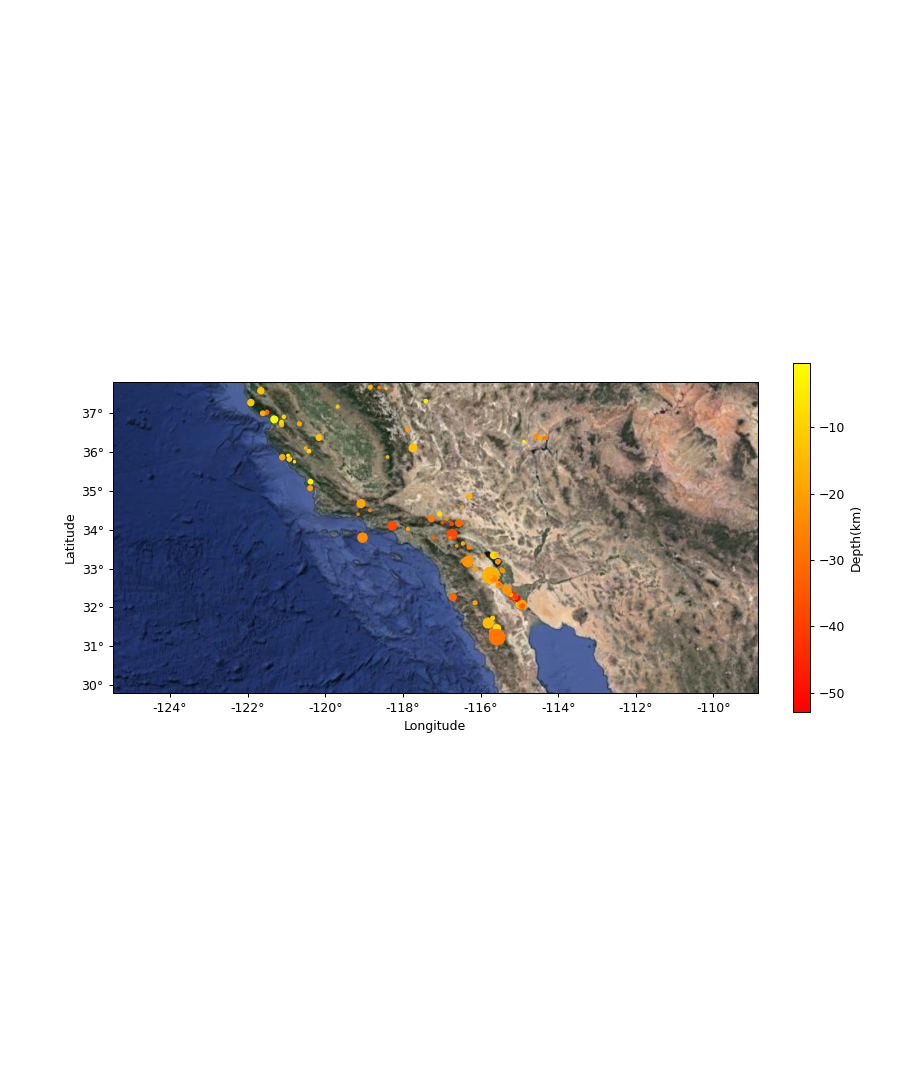

In [96]:
%matplotlib notebook 
#%matplotlib inline

fig, ax = plt.subplots(1, 1)
x_lim=[-2.19*180/np.pi,-1.90*180/np.pi]
y_lim=[0.52*180/np.pi,0.66*180/np.pi]

fig.set_size_inches(10,12)
background=plt.imread('california.jpeg')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

plot=ax.scatter(np.zeros(len(df)),np.zeros(len(df)),c=df['Depth'],cmap='autumn') ##'mock' plot for the colorbar
   
cb=fig.colorbar(plot,fraction=0.025,label='Depth(km)') #color bar


speed=100

def animate(i):
    j1=int(intervales[i])
    j2=int(intervales[i+1])
    ax.clear()
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
    ax.yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))


    
    data_=df.iloc[j1:j2]
    
    ax.imshow(background,extent=[x_lim[0],x_lim[1],y_lim[0],y_lim[1]]) ##map of california
    ax.scatter(data_['Longitude'],data_['Latitude'],c=data_['Depth'],s=data_['Magnitude']**5/10,cmap='autumn')
    #ax.set_title(df['year'][j])
    

ani = FuncAnimation(fig, func=animate, frames=int(len(intervales)-1),
                    interval=speed, repeat=False)

### 2.2. 3D plot of events with depth highlighted by color

By plotting the 3D points corresponding to the geodetic coordinates, the silhouette of the fault lines can be seen. If we observe the graph with all the earthquakes in the dataframe (magnitude > 2), we can see that earthquakes tend to align vertically in a specific range of coordinates. These vertical lines show the depth of the active lines in the San Andreas fault. If, on the contrary, we look at the distribution of data from above (on a 2D map of California, like in the animation), we can see that the earthquakes tend to align along approximately straight lines that extend north-west to south-east.

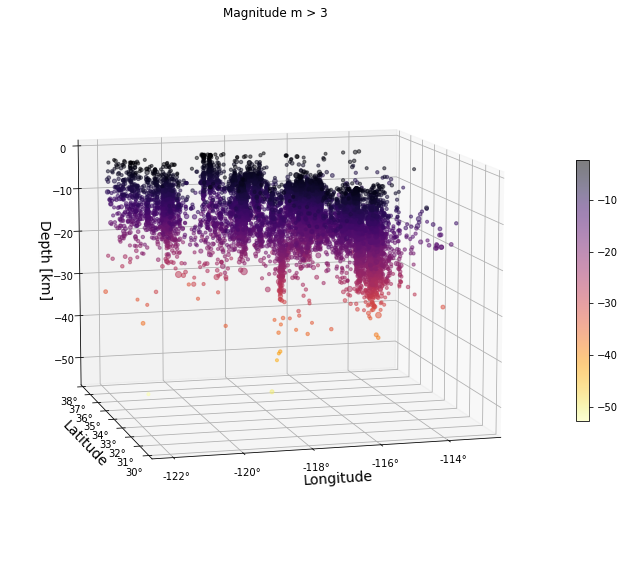

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection="3d")

m = 3

lon = df["Longitude"][df["Magnitude"]>m]
lat = df["Latitude"][df["Magnitude"]>m]
depth = df["Depth"][df["Magnitude"]>m]
mag = df['Magnitude'][df['Magnitude']>m]

plot3d = ax.scatter3D(lon,lat,depth,s=mag**2,c=depth,alpha=0.5,cmap="inferno_r")
color = plt.colorbar(plot3d,ax=ax,shrink=0.4)
ax.set_title("Magnitude m > "+str(m))
ax.set_xlabel("Longitude",fontsize=14)
ax.set_ylabel("Latitude",fontsize=14)
ax.set_zlabel("Depth [km]",fontsize=14)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
ax.yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
ax.view_init(azim = 255, elev = 10)
plt.show()

### 2.3. Time series 

The greater an earthquake's magnitude, the more likely it is to trigger a cascade of aftershocks. By plotting the number of earthquakes recorded each day over the entire timespan of 30 years, it is clear that there are only a few devastating earthquakes that light up the map of California with seismic activity. 

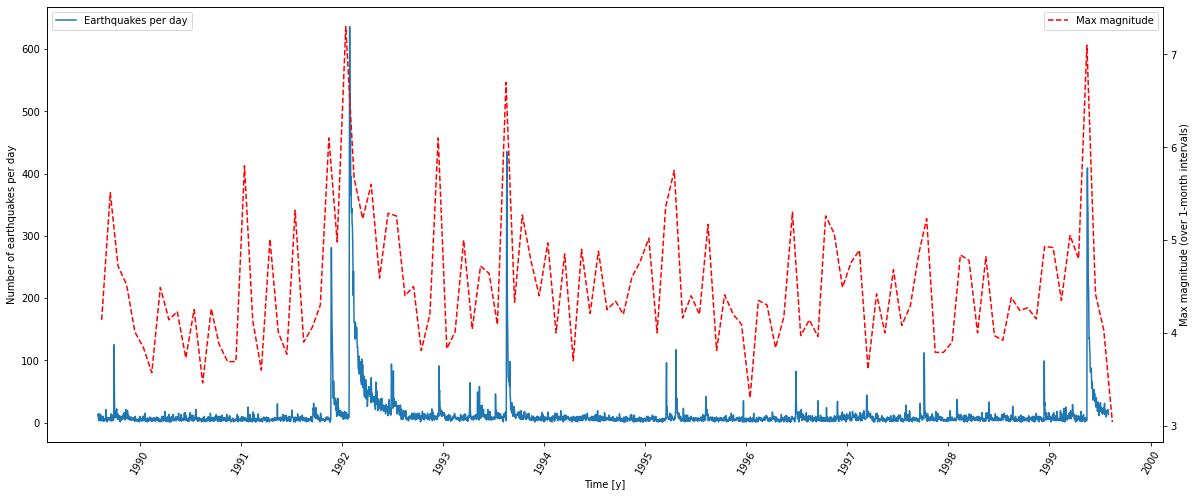

In [8]:
%matplotlib inline

start_date = "1990-01-01"
end_date   = "2000-01-01"

d2 = event_finder(start_date,end_date,df)[1]

date = pd.to_datetime(d2["Timestamp"]).dt.date
unique_dates = date.unique()
n_events_per_day = date.groupby(date).count()
max_magnitude = df.groupby(date, sort=False)["Magnitude"].max()

months = date.apply(lambda dt: dt.replace(day=15))
unique_months = months.unique()
max_magnitude_months = df.groupby(months, sort=False)["Magnitude"].max()

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x=unique_dates,y=n_events_per_day,label='Earthquakes per day')
ax.tick_params(axis="x",rotation = 60)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_ylabel("Number of earthquakes per day")
ax.set_xlabel('Time [y]')
ax.legend(loc='upper left')
ax2 = plt.twinx()
ax2 = sns.lineplot(x=unique_months,y=max_magnitude_months,ax=ax2,color='red',linestyle="--",label='Max magnitude')
ax2.set_ylabel("Max magnitude (over 1-month intervals)")
ax2.legend(loc='best')

plt.show()

### 2.4. Depth, latitude, longitude time series

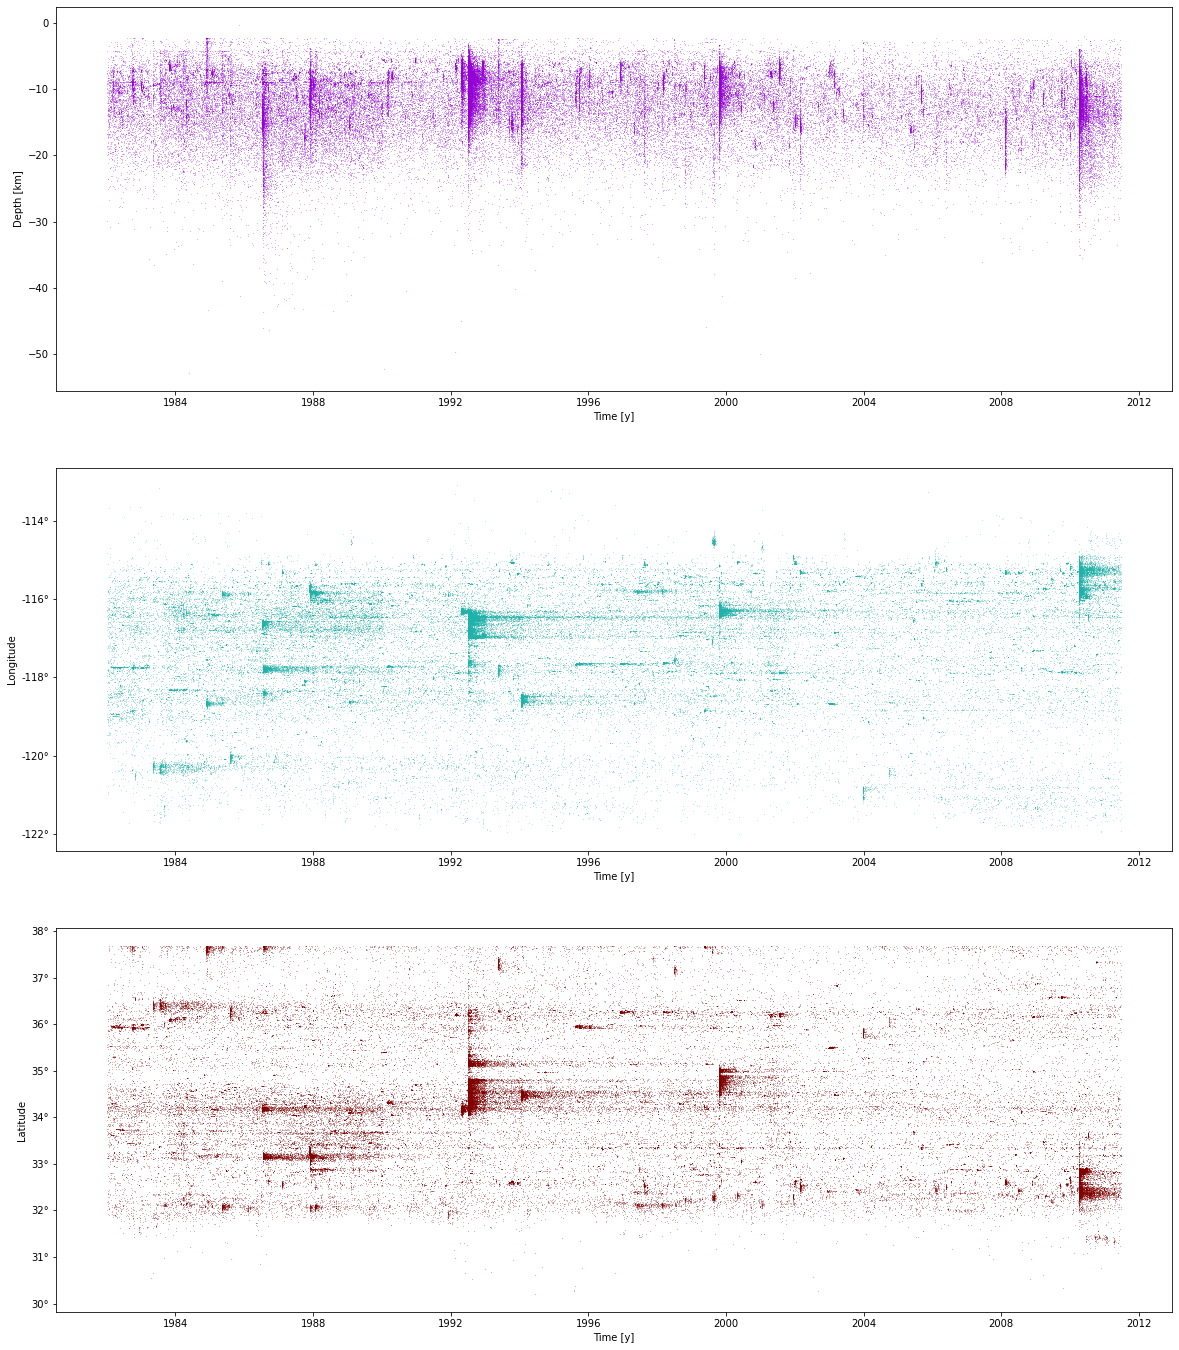

In [9]:
m = 2

time = df['Timestamp'][df["Magnitude"]>m]
depth = df["Depth"][df["Magnitude"]>m]
lon = df["Longitude"][df["Magnitude"]>m]
lat = df["Latitude"][df["Magnitude"]>m]

fig, axes = plt.subplots(3,1,figsize=(20,24))
sns.scatterplot(x=time, y=depth, s=1, marker='.', color='darkviolet',edgecolor=None,ax=axes[0])
axes[0].set(xlabel='Time [y]')
axes[0].set(ylabel="Depth [km]")

sns.scatterplot(x=time, y=lon, s=1, marker='.', color='lightseagreen',edgecolor=None,ax=axes[1])
axes[1].set(xlabel='Time [y]')
axes[1].set(ylabel="Longitude")
axes[1].yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))

sns.scatterplot(x=time, y=lat, s=1, marker='.', color='maroon',edgecolor=None,ax=axes[2])
axes[2].set(xlabel='Time [y]')
axes[2].set(ylabel="Latitude")
axes[2].yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))

plt.show()

,ID,Trigger,Timestamp,Time,Magnitude,X,Y,Z,Longitude,Latitude,Depth
0,0,-1,1982-01-02 11:17:49.470000000,0.000000e+00,2.71,-2571956,-4627162,3520602,-119.067002,33.803070,-13.866339
1,1,0,1982-01-02 21:26:10.860720000,3.650139e+04,2.12,-2363740,-4787011,3461373,-116.279332,33.133255,-9.094155
2,2,0,1982-01-02 21:42:37.747440000,3.748828e+04,2.33,-2363746,-4786942,3461232,-116.279718,33.132481,-9.220807
3,3,0,1982-01-03 00:37:31.986480000,4.798252e+04,2.57,-2475085,-4664024,3548479,-117.953814,34.081790,-9.788561
4,4,0,1982-01-03 04:02:18.040560000,6.026857e+04,2.98,-2238642,-4839098,3469546,-114.825995,33.229464,-10.453019
...,...,...,...,...,...,...,...,...,...,...,...
110266,110266,-1,2011-06-29 03:23:57.640560128,9.304996e+08,2.60,-2668492,-4335735,3810743,-121.610832,37.000291,-11.092891
110267,110267,-1,2011-06-29 06:42:54.198000128,9.305115e+08,2.02,-2297480,-4823870,3445285,-115.467209,32.990515,-14.309252
110268,110268,-1,2011-06-29 12:21:05.203440128,9.305318e+08,2.00,-2404797,-4441247,3868121,-118.434166,37.634193,-8.595471
110269,110269,-1,2011-06-29 13:35:38.070960128,9.305363e+08,2.17,-2388375,-4691191,3550903,-116.981514,34.180503,-21.582249


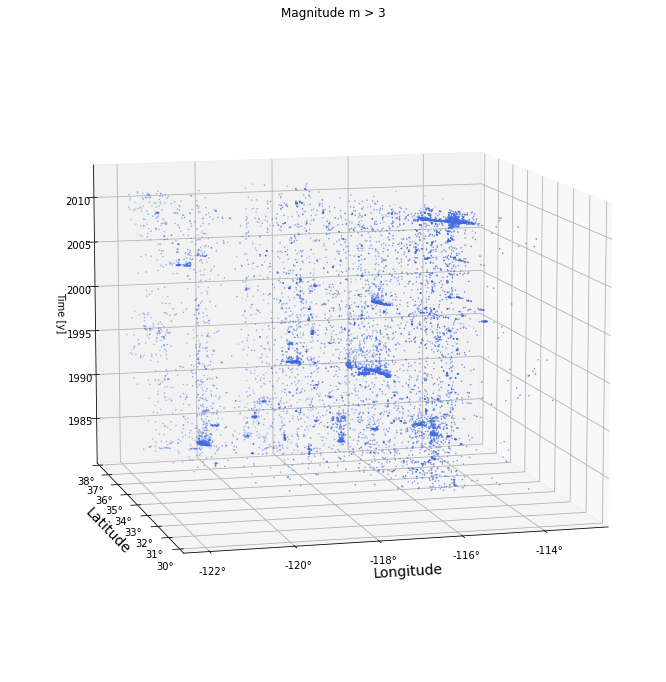

In [10]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection="3d")

start = "1982-01-01"
end = "2011-06-29"

df2 = event_finder(start,end,df)[1]
display(df2)

m = 3

lon = df2["Longitude"][df2["Magnitude"]>m]
lat = df2["Latitude"][df2["Magnitude"]>m]

time = (df2["Time"][df2["Magnitude"]>m].to_numpy())*1e9 + time0
UNIXyear = 31556926*1e9
years = 1970 + time/UNIXyear

plot3d = ax.scatter3D(lon,lat,years,s=1,marker=".",color="royalblue")
ax.set_title("Magnitude m > "+str(m))
ax.set_xlabel("Longitude",fontsize=14)
ax.set_ylabel("Latitude",fontsize=14)
ax.set_zlabel("Time [y]")
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
ax.yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
ax.view_init(azim = 255, elev = 10)
plt.show()

### 2.5. Searching for correlations in the data

As stated at the begining, joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees joining earthquakes with their triggers. This encouraged us to study the correlation between the number of events an earthquake triggers and its magnitude and depth.

In [11]:
#k is a pandas series that shows the number of earthquakes triggered by a certain earthquake (that is, the number of rows that have a certain same number in the 'trigger' column).
#y1 is the array of number of triggers by each triggering earthquake
k=df.groupby('Trigger')['ID'].nunique()
y=k.values[1:]


#x1 is the array of magnitudes of triggering earthquakes
#xm is the mean of the magnitudes of triggering earthquakes
x1=df['Magnitude'][list(k.index)[1:]].values
xm = df.iloc[list(k.index)[1:]]['Magnitude'].mean()


#total is the list of indexes of triggering earthquakes, counting each one as many times as number of events they trigger
total=[]
for i in range(k[1:].size):
    lista=[k[1:].index[i]]*k[1:].values[i]
    total=total+lista

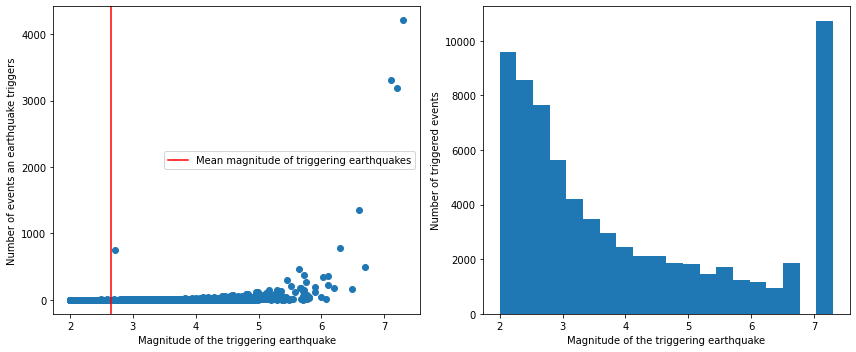

In [12]:
%matplotlib inline
fig, (ax1, ax2) =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.scatter(x1,y)
ax1.axvline(xm, color = 'r', label = 'Mean magnitude of triggering earthquakes')
ax1.set_xlabel('Magnitude of the triggering earthquake')
ax1.set_ylabel('Number of events an earthquake triggers')
ax1.legend(loc='best')


ax2.hist(df.iloc[total]['Magnitude'].values, bins=20)
ax2.set_xlabel('Magnitude of the triggering earthquake')
ax2.set_ylabel('Number of triggered events')

fig.tight_layout()

In the previous figure, two plots are represented. In the left one we can see a scatter plot that shows the number of events an earthquake triggers as a funcion of its magnitude. The conclusion that we can yield from this is that __higher magnitude earthquakes tend to trigger a larger number of events__. In the same graph, the mean magnitude of triggering earthquakes is plotted. Such mean value  of magnitude is around 2.6, which leads us to think that most of the triggered events must have been provoked by lower magnitude earthquakes. In fact, this is what we can appreciate in the right hand side of the figure, which shows the number of triggered events as a function of the magnitude of the triggering earthquakes. There, we can see that __most of the triggered events where triggered by lower magnitude earthquakes__. The reason for this to happen is that __there is a notable higher amount of data for magnitudes around 2-3 than for magnitudes above 5__.

In [13]:
#x2 is the array of magnitudes of triggering earthquakes
#xd is the mean of the depths of triggering earthquakes
x2=df['Depth'][list(k.index)[1:]].values
xd= df.iloc[list(k.index)[1:]]['Depth'].mean()

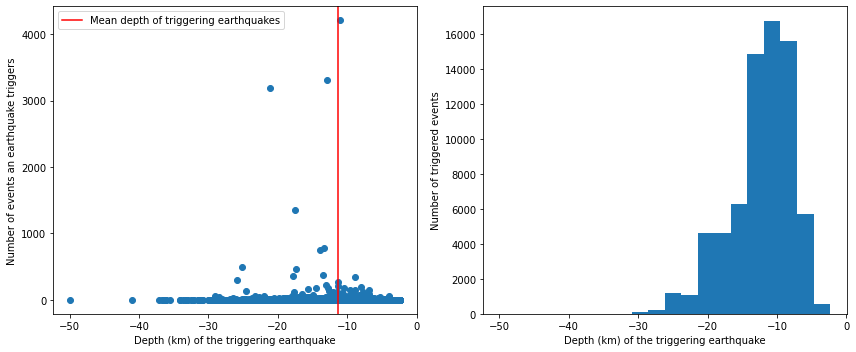

In [14]:
%matplotlib inline
fig, (ax1, ax2) =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.scatter(x2,y)
ax1.axvline(xd, color = 'r', label = 'Mean depth of triggering earthquakes')
ax1.set_xlabel('Depth (km) of the triggering earthquake')
ax1.set_ylabel('Number of events an earthquake triggers')
ax1.legend(loc='best')


ax2.hist(df.iloc[total]['Depth'].values, bins=20)
ax2.set_xlabel('Depth (km) of the triggering earthquake')
ax2.set_ylabel('Number of triggered events')

fig.tight_layout()

Following the same process, we plotted the number of aftershocks as a function of depth. What we find is that earthquakes that happen closer to the surface tend to trigger more events.

Also, we decided to study wether or not there was a correlation between the magnitude and depth of the earthquakes. It does not seem so. Most of the earthquakes in the data are small magnitude and close to the surface ones. However, higher magnitudes do not seem to be related to greater depths.

In [15]:
a=np.zeros((len(df)))
ind=k.index[1:]
val=k.values[1:]
for i in range(ind.size):
    a[ind[i]]=val[i]

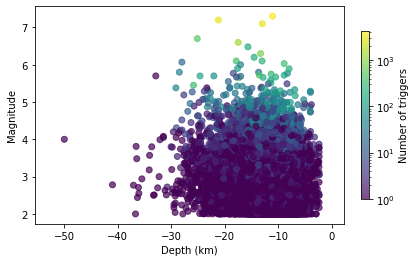

In [16]:
%matplotlib inline

plot=plt.scatter(df['Depth'],df['Magnitude'], c=a, alpha=0.7, norm=plt_c.LogNorm())
plt.colorbar(plot,fraction=0.025,label='Number of triggers')
plt.ylabel('Magnitude')
plt.xlabel('Depth (km)')
plt.show()

### 2.6. Causal trees:

We reconstructed the chain of aftershocks starting from an arbitrary earthquake. We then plot the time difference and the distance of each aftershock from the initial main shock.

In [17]:
def trigger_chain(ID,df):
    l = [ID]
    while ID != -1:
        ID = df.iloc[ID]["Trigger"]
        l.append(ID)
    chain = np.array(l)

    return chain


def aftershock_chains(ID,n_branches,df):
    d = {(ID,):None}

    for n in range(n_branches):
        for triggers in list(d.keys()):
            aftershocks = df[df["Trigger"] == triggers[-1]].index.to_list()
            d[triggers] = {(j,):None for j in aftershocks}
        d = flatten(d,keep_empty_types=(dict,))

        for triggers in list(d.keys()):
            t = tuple([id for tupl in triggers for id in tupl])
            d[t] = d.pop(triggers)
    return d


def dist(ID0,ID1,data):
    d = np.sqrt((data.iloc[ID0]["X"]-data.iloc[ID1]["X"])**2 + (data.iloc[ID0]["Y"]-data.iloc[ID1]["Y"])**2 + (data.iloc[ID0]["Z"]-data.iloc[ID1]["Z"])**2)
    return d/1000

def time(ID0,ID1,data):
    t = data.iloc[ID1]["Time"] - data.iloc[ID0]["Time"]
    return t

#### Plot chains of aftershocks

[15481, 15482, 15495, 15499, 15505, 15514, 15515, 15527, 15528, 15530, 15532, 15544, 15552, 15555, 15558, 15559, 15561, 15563, 15607, 15609, 15882, 15884, 15938, 32522]


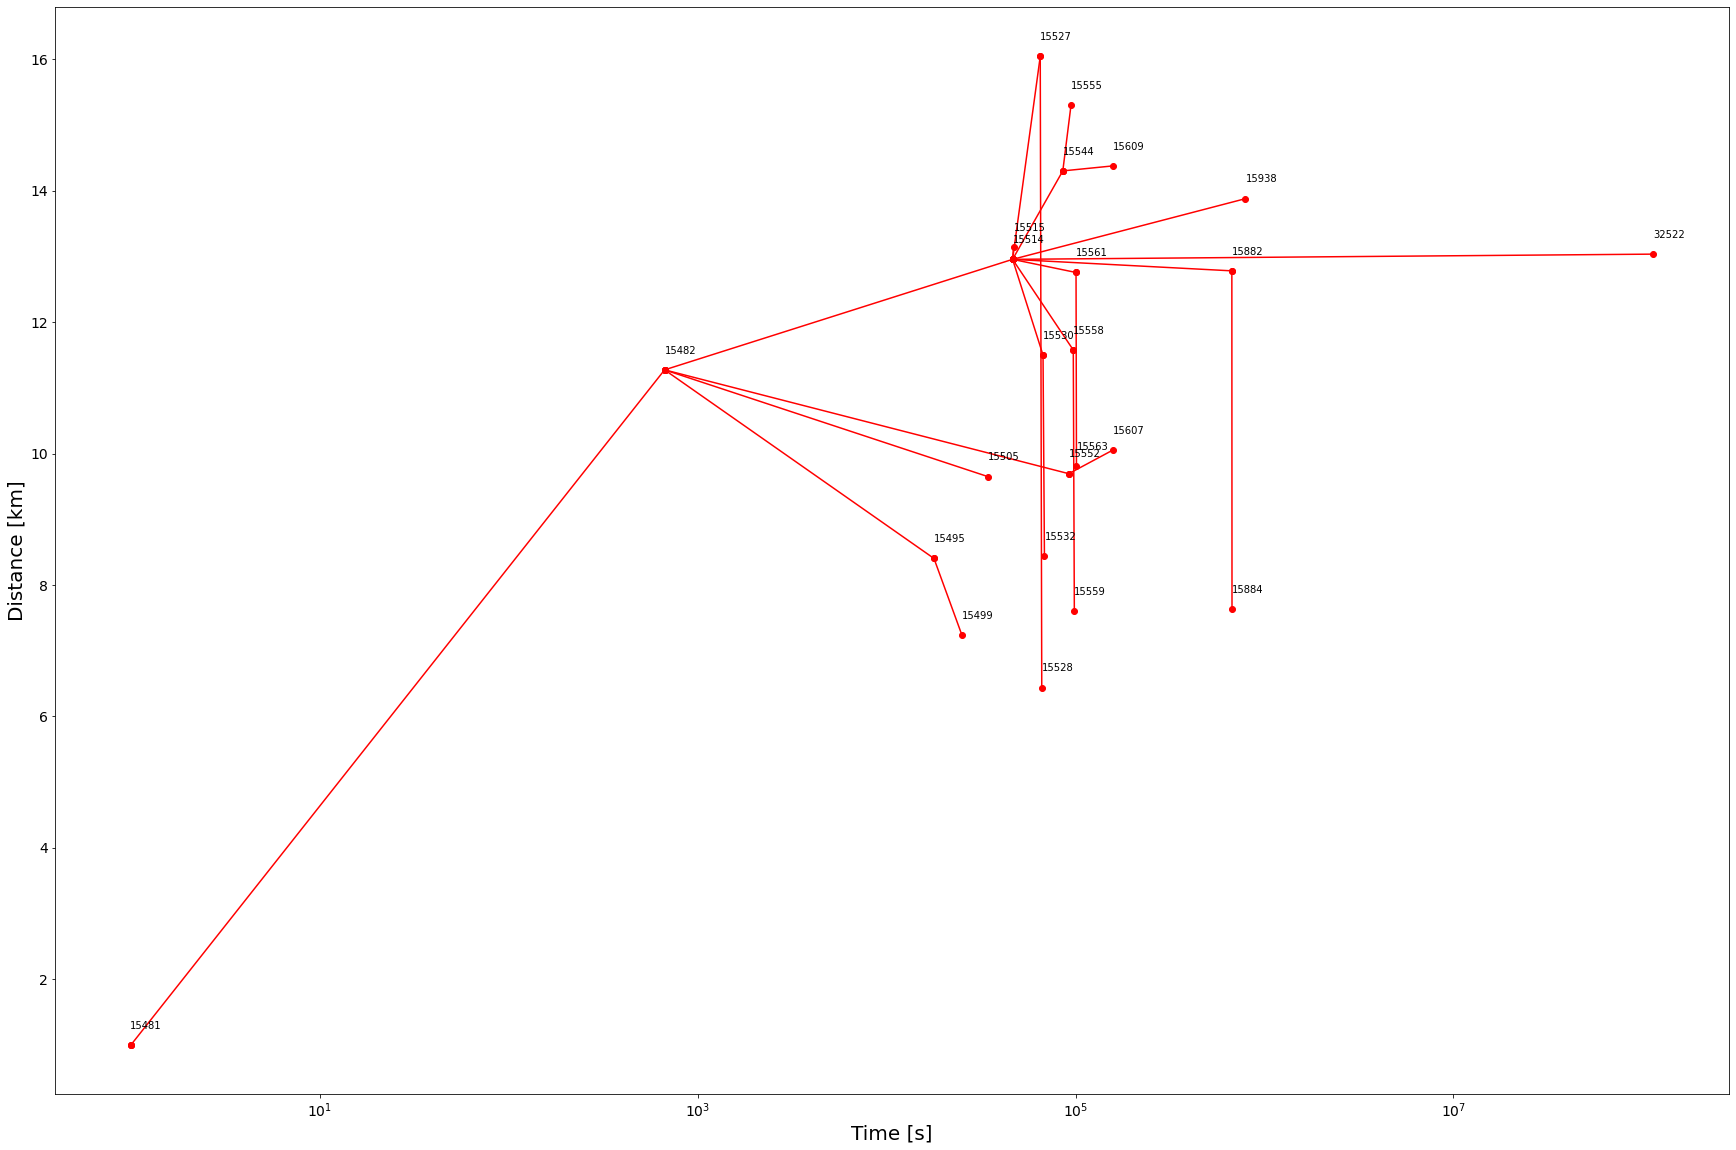

In [18]:
def plot_chains(ID,n_branches,data):
    ID_chains = aftershock_chains(ID,n_branches,data)
    fig = plt.figure(figsize=(30,20))
    ID_list = set()
    for id_chain in list(ID_chains.keys()):
        prev_d = dist(ID,id_chain[0],data) + 1
        prev_t = time(ID,id_chain[0],data) + 1
        for id in id_chain:
            if id == id_chain[0]:
                d = dist(ID,id,data) + 1
                t = time(ID,id,data) + 1
            else:
                d = dist(ID,id,data)
                t = time(ID,id,data)
            if id not in ID_list:
                plt.plot([prev_t,t],[prev_d,d],"ro-")
                plt.text(t-0.015, d+0.25, str(id))
            prev_d = d
            prev_t = t
            ID_list.add(id)
    plt.xscale("log")
    plt.xlabel("Time [s]",fontsize=20)
    plt.ylabel("Distance [km]",fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return sorted(ID_list)

print(plot_chains(15481,4,df))

* We identify in earthquake number 39805 the Landers earthquake of 1992, with magnitude 7.3.

In [19]:
print(trigger_chain(39805,df))

[39805 39804 39802 39800 39799 39798 39790 39789 39787 39783 39782    -1]


In [20]:
l = [39782, 39783, 39784, 39785, 39786, 39787, 39788, 39789, 39790, 39791, 39792, 39793, 39794, 39795, 39796, 39797, 39798, 39799, 39800, 39801, 39802, 39803, 39804, 39805, 39806, 39807, 39808, 39809, 39810, 39811, 39812, 39813, 39814, 39815, 39816, 39817, 39818, 39819, 39820, 39821, 39822, 39823, 39824, 39825, 39826, 39828, 39829, 39830, 39831, 39832, 39834, 39835, 39836, 39837, 39838, 39839, 39841, 39842, 39843, 39844, 39845, 39846, 39847, 39848, 39850, 39851, 39852, 39854, 39855, 39857, 39873, 39878, 39885, 39886, 39888, 39889, 39899, 39900, 39902, 39903, 39904, 39907, 39908, 39911, 39913, 39917, 39919, 39920, 39921, 39922, 39923, 39926, 39927, 39932, 39933, 39934, 39944, 39947, 39949, 39964, 39969, 39970, 39971, 39979, 39980, 39981, 39982, 39983, 39987, 39988, 39990, 39991, 39994, 39995, 39996, 39997, 39999, 40005, 40006, 40007, 40009, 40010, 40011, 40012, 40015, 40017, 40018, 40019, 40020, 40021, 40022, 40023, 40025, 40026, 40027, 40028, 40029, 40032, 40034, 40036, 40037, 40038, 40039, 40041, 40044, 40045, 40047, 40048, 40049, 40050, 40051, 40055, 40056, 40057, 40060, 40064, 40065, 40066, 40068, 40070, 40071, 40073, 40076, 40080, 40081, 40082, 40084, 40089, 40090, 40094, 40097, 40099, 40101, 40102, 40103, 40104, 40105, 40106, 40107, 40111, 40118, 40122, 40128, 40129, 40132, 40133, 40140, 40141, 40143, 40148, 40149, 40150, 40152, 40153, 40155, 40156, 40157, 40159, 40162, 40166, 40167, 40169, 40170, 40172, 40173, 40179, 40184, 40186, 40188, 40191, 40193, 40194, 40197, 40198, 40199, 40200, 40203, 40207, 40208, 40210, 40212, 40216, 40218, 40219, 40224, 40226, 40227, 40229, 40232, 40233, 40234, 40235, 40236, 40238, 40243, 40244, 40247, 40248, 40250, 40252, 40253, 40254, 40258, 40259, 40260, 40264, 40265, 40266, 40267, 40272, 40273, 40277, 40278, 40279, 40280, 40284, 40285, 40286, 40290, 40292, 40296, 40297, 40298, 40301, 40303, 40305, 40306, 40310, 40312, 40313, 40315, 40320, 40321, 40322, 40323, 40324, 40325, 40326, 40327, 40330, 40331, 40332, 40333, 40335, 40336, 40337, 40339, 40340, 40341, 40342, 40343, 40344, 40345, 40348, 40352, 40353, 40358, 40359, 40360, 40361, 40362, 40363, 40364, 40365, 40368, 40369, 40372, 40373, 40374, 40375, 40378, 40380, 40382, 40383, 40385, 40388, 40391, 40393, 40394, 40398, 40399, 40402, 40403, 40404, 40407, 40408, 40409, 40410, 40414, 40415, 40421, 40422, 40424, 40425, 40428, 40430, 40435, 40437, 40440, 40442, 40444, 40445, 40450, 40455, 40457, 40458, 40459, 40460, 40463, 40469, 40470, 40471, 40472, 40473, 40474, 40476, 40477, 40478, 40480, 40486, 40491, 40493, 40494, 40496, 40497, 40498, 40504, 40507, 40509, 40512, 40513, 40514, 40516, 40519, 40521, 40522, 40523, 40529, 40530, 40532, 40534, 40535, 40536, 40539, 40540, 40542, 40545, 40547, 40548, 40549, 40551, 40553, 40555, 40559, 40560, 40568, 40569, 40570, 40571, 40572, 40574, 40575, 40576, 40577, 40579, 40580, 40581, 40583, 40584, 40596, 40609, 40622, 40624, 40634, 40636, 40638, 40657, 40662, 40672, 40673, 40679, 40682, 40684, 40685, 40689, 40690, 40692, 40698, 40699, 40704, 40705, 40708, 40711, 40714, 40715, 40717, 40718, 40719, 40721, 40723, 40725, 40726, 40732, 40734, 40741, 40744, 40745, 40748, 40749, 40750, 40752, 40753, 40755, 40759, 40762, 40767, 40770, 40774, 40776, 40778, 40779, 40780, 40783, 40786, 40790, 40791, 40794, 40796, 40799, 40800, 40807, 40808, 40809, 40810, 40812, 40815, 40817, 40818, 40819, 40820, 40822, 40823, 40826, 40829, 40831, 40835, 40836, 40837, 40840, 40843, 40846, 40848, 40850, 40856, 40862, 40865, 40867, 40868, 40869, 40870, 40872, 40874, 40875, 40877, 40879, 40880, 40885, 40886, 40887, 40888, 40892, 40895, 40899, 40902, 40903, 40904, 40909, 40910, 40914, 40915, 40919, 40920, 40921, 40922, 40928, 40930, 40932, 40933, 40936, 40939, 40940, 40941, 40943, 40944, 40947, 40951, 40952, 40953, 40955, 40957, 40958, 40962, 40963, 40966, 40969, 40971, 40974, 40975, 40977, 40980, 40981, 40982, 40993, 40994, 40995, 40996, 40998, 41000, 41003, 41004, 41005, 41007, 41009, 41013, 41014, 41016, 41023, 41024, 41025, 41030, 41031, 41033, 41035, 41037, 41040, 41041, 41047, 41050, 41054, 41055, 41056, 41058, 41059, 41065, 41067, 41070, 41073, 41078, 41084, 41085, 41087, 41089, 41090, 41092, 41094, 41096, 41097, 41102, 41103, 41106, 41126, 41127, 41129, 41130, 41133, 41141, 41147, 41150, 41151, 41156, 41159, 41160, 41163, 41169, 41170, 41172, 41176, 41182, 41186, 41188, 41190, 41193, 41206, 41210, 41215, 41216, 41222, 41228, 41233, 41236, 41237, 41245, 41247, 41248, 41257, 41260, 41263, 41266, 41277, 41284, 41286, 41287, 41288, 41290, 41291, 41292, 41293, 41294, 41295, 41297, 41298, 41316, 41321, 41331, 41332, 41333, 41345, 41346, 41348, 41351, 41356, 41357, 41358, 41359, 41366, 41370, 41372, 41373, 41385, 41387, 41388, 41392, 41393, 41394, 41395, 41397, 41398, 41404, 41409, 41411, 41415, 41420, 41421, 41423, 41426, 41428, 41429, 41430, 41431, 41433, 41436, 41440, 41441, 41443, 41444, 41446, 41447, 41450, 41451, 41453, 41455, 41457, 41459, 41463, 41469, 41471, 41472, 41473, 41474, 41476, 41479, 41485, 41486, 41490, 41491, 41493, 41497, 41499, 41503, 41506, 41511, 41522, 41530, 41534, 41537, 41538, 41548, 41549, 41560, 41562, 41577, 41580, 41581, 41589, 41595, 41614, 41615, 41617, 41626, 41628, 41634, 41637, 41638, 41641, 41644, 41646, 41647, 41651, 41654, 41656, 41657, 41660, 41663, 41664, 41667, 41670, 41677, 41679, 41680, 41681, 41684, 41685, 41689, 41690, 41693, 41702, 41703, 41705, 41706, 41708, 41709, 41711, 41723, 41731, 41733, 41736, 41740, 41746, 41747, 41748, 41749, 41754, 41755, 41756, 41762, 41765, 41769, 41773, 41775, 41778, 41780, 41786, 41793, 41799, 41801, 41804, 41805, 41811, 41816, 41818, 41819, 41825, 41828, 41831, 41834, 41837, 41839, 41840, 41844, 41845, 41854, 41857, 41859, 41860, 41863, 41867, 41869, 41870, 41871, 41872, 41873, 41883, 41890, 41895, 41896, 41902, 41903, 41904, 41905, 41908, 41909, 41913, 41915, 41916, 41918, 41919, 41922, 41923, 41927, 41928, 41932, 41935, 41939, 41942, 41943, 41949, 41953, 41954, 41956, 41957, 41962, 41963, 41967, 41975, 41976, 41992, 41997, 41998, 42004, 42005, 42008, 42010, 42011, 42014, 42016, 42017, 42020, 42021, 42038, 42041, 42043, 42047, 42052, 42057, 42059, 42060, 42061, 42063, 42064, 42065, 42066, 42070, 42072, 42078, 42079, 42080, 42081, 42082, 42084, 42090, 42091, 42096, 42102, 42104, 42106, 42107, 42108, 42110, 42112, 42117, 42122, 42124, 42129, 42130, 42138, 42142, 42145, 42149, 42153, 42157, 42158, 42160, 42161, 42164, 42169, 42175, 42183, 42186, 42188, 42190, 42191, 42193, 42203, 42206, 42211, 42212, 42215, 42221, 42223, 42226, 42227, 42228, 42236, 42238, 42239, 42251, 42253, 42254, 42255, 42257, 42261, 42263, 42266, 42271, 42277, 42280, 42283, 42290, 42297, 42299, 42301, 42305, 42307, 42309, 42314, 42318, 42320, 42327, 42329, 42333, 42334, 42338, 42339, 42341, 42344, 42345, 42346, 42347, 42348, 42350, 42353, 42354, 42356, 42359, 42360, 42361, 42366, 42368, 42369, 42371, 42373, 42376, 42377, 42378, 42389, 42390, 42393, 42395, 42398, 42400, 42406, 42407, 42408, 42413, 42415, 42416, 42417, 42420, 42423, 42425, 42430, 42432, 42438, 42446, 42447, 42449, 42454, 42456, 42458, 42462, 42464, 42467, 42468, 42469, 42470, 42473, 42475, 42477, 42478, 42479, 42481, 42482, 42490, 42491, 42492, 42501, 42503, 42504, 42510, 42511, 42516, 42521, 42523, 42527, 42531, 42534, 42539, 42540, 42541, 42542, 42547, 42548, 42552, 42555, 42560, 42565, 42567, 42568, 42571, 42573, 42578, 42580, 42584, 42592, 42595, 42596, 42598, 42603, 42604, 42606, 42608, 42611, 42612, 42618, 42624, 42628, 42632, 42639, 42642, 42652, 42653, 42655, 42656, 42662, 42668, 42672, 42678, 42681, 42686, 42694, 42699, 42700, 42701, 42704, 42706, 42708, 42711, 42714, 42715, 42716, 42718, 42723, 42725, 42727, 42728, 42730, 42735, 42736, 42737, 42740, 42746, 42748, 42751, 42757, 42762, 42765, 42767, 42769, 42771, 42773, 42774, 42777, 42780, 42784, 42792, 42793, 42796, 42798, 42799, 42800, 42801, 42804, 42810, 42811, 42813, 42818, 42820, 42823, 42824, 42825, 42826, 42831, 42835, 42837, 42843, 42848, 42849, 42854, 42855, 42857, 42859, 42860, 42865, 42868, 42869, 42870, 42874, 42875, 42884, 42893, 42895, 42896, 42897, 42898, 42901, 42903, 42906, 42907, 42908, 42909, 42910, 42912, 42913, 42916, 42922, 42932, 42933, 42936, 42937, 42939, 42942, 42945, 42948, 42951, 42953, 42955, 42958, 42963, 42966, 42968, 42973, 42977, 42984, 42985, 42998, 43005, 43017, 43019, 43021, 43022, 43026, 43030, 43034, 43036, 43040, 43045, 43055, 43058, 43059, 43061, 43062, 43071, 43074, 43077, 43082, 43083, 43084, 43087, 43089, 43090, 43092, 43095, 43096, 43097, 43101, 43103, 43104, 43106, 43107, 43113, 43115, 43117, 43118, 43123, 43124, 43125, 43126, 43128, 43135, 43138, 43153, 43154, 43157, 43158, 43159, 43164, 43165, 43167, 43171, 43173, 43177, 43179, 43180, 43181, 43182, 43184, 43201, 43202, 43205, 43206, 43207, 43219, 43220, 43224, 43225, 43228, 43230, 43231, 43242, 43244, 43263, 43268, 43269, 43275, 43276, 43280, 43287, 43288, 43292, 43293, 43296, 43298, 43300, 43301, 43305, 43308, 43311, 43312, 43315, 43316, 43319, 43321, 43322, 43323, 43325, 43327, 43329, 43338, 43339, 43340, 43342, 43346, 43352, 43357, 43380, 43382, 43386, 43389, 43400, 43412, 43419, 43421, 43429, 43434, 43440, 43443, 43445, 43447, 43449, 43458, 43461, 43469, 43470, 43476, 43480, 43482, 43483, 43484, 43486, 43489, 43490, 43493, 43495, 43505, 43509, 43513, 43515, 43517, 43518, 43519, 43521, 43522, 43527, 43530, 43535, 43538, 43541, 43542, 43546, 43549, 43551, 43554, 43556, 43561, 43566, 43569, 43581, 43589, 43597, 43600, 43605, 43606, 43608, 43612, 43618, 43619, 43625, 43637, 43638, 43641, 43643, 43644, 43647, 43650, 43664, 43665, 43668, 43669, 43672, 43676, 43682, 43685, 43692, 43701, 43730, 43733, 43739, 43755, 43758, 43761, 43766, 43767, 43770, 43775, 43776, 43777, 43779, 43783, 43784, 43813, 43817, 43818, 43823, 43825, 43830, 43835, 43836, 43837, 43844, 43856, 43857, 43858, 43863, 43868, 43870, 43872, 43877, 43879, 43880, 43888, 43893, 43906, 43912, 43915, 43916, 43938, 43941, 43944, 43948, 43949, 43952, 43960, 43961, 43968, 43972, 43976, 43977, 43987, 43990, 43994, 43998, 44000, 44003, 44005, 44009, 44010, 44013, 44015, 44016, 44022, 44023, 44027, 44028, 44030, 44032, 44038, 44039, 44043, 44051, 44052, 44054, 44055, 44057, 44062, 44064, 44065, 44074, 44075, 44077, 44083, 44085, 44088, 44089, 44092, 44095, 44127, 44128, 44129, 44130, 44143, 44144, 44145, 44146, 44148, 44149, 44157, 44160, 44162, 44164, 44173, 44175, 44179, 44180, 44183, 44184, 44186, 44189, 44191, 44194, 44198, 44200, 44202, 44211, 44212, 44214, 44215, 44216, 44218, 44221, 44224, 44227, 44230, 44234, 44235, 44238, 44241, 44243, 44245, 44250, 44254, 44256, 44257, 44271, 44272, 44274, 44278, 44284, 44285, 44286, 44287, 44289, 44291, 44293, 44296, 44301, 44304, 44309, 44313, 44316, 44333, 44336, 44337, 44342, 44349, 44350, 44352, 44355, 44356, 44358, 44365, 44367, 44369, 44378, 44380, 44381, 44382, 44384, 44398, 44399, 44407, 44408, 44417, 44418, 44419, 44421, 44422, 44427, 44430, 44433, 44436, 44439, 44443, 44445, 44449, 44451, 44475, 44482, 44490, 44499, 44502, 44509, 44511, 44513, 44525, 44528, 44531, 44532, 44535, 44540, 44542, 44543, 44545, 44547, 44548, 44553, 44556, 44561, 44570, 44574, 44577, 44579, 44581, 44582, 44593, 44597, 44602, 44605, 44607, 44610, 44611, 44618, 44623, 44625, 44628, 44631, 44632, 44634, 44637, 44641, 44643, 44645, 44647, 44649, 44650, 44652, 44656, 44661, 44664, 44665, 44669, 44670, 44674, 44684, 44686, 44687, 44689, 44690, 44695, 44697, 44699, 44703, 44718, 44719, 44726, 44729, 44732, 44736, 44737, 44738, 44739, 44740, 44745, 44749, 44757, 44762, 44768, 44769, 44771, 44773, 44780, 44794, 44796, 44801, 44802, 44803, 44805, 44809, 44811, 44812, 44815, 44817, 44825, 44831, 44835, 44845, 44849, 44850, 44854, 44859, 44861, 44867, 44870, 44872, 44875, 44878, 44890, 44892, 44896, 44899, 44900, 44902, 44903, 44904, 44905, 44906, 44909, 44912, 44917, 44918, 44919, 44925, 44927, 44930, 44932, 44933, 44935, 44937, 44939, 44940, 44944, 44948, 44950, 44951, 44953, 44957, 44965, 44975, 44981, 44991, 44996, 45002, 45008, 45009, 45010, 45012, 45013, 45017, 45019, 45021, 45025, 45030, 45031, 45039, 45052, 45062, 45064, 45075, 45079, 45082, 45085, 45090, 45092, 45093, 45099, 45100, 45102, 45103, 45106, 45107, 45114, 45117, 45125, 45127, 45135, 45136, 45139, 45140, 45141, 45144, 45145, 45152, 45153, 45155, 45157, 45158, 45160, 45161, 45162, 45164, 45165, 45166, 45167, 45168, 45173, 45179, 45181, 45188, 45190, 45193, 45196, 45198, 45200, 45201, 45205, 45206, 45216, 45219, 45221, 45222, 45224, 45232, 45236, 45242, 45247, 45249, 45253, 45255, 45258, 45259, 45264, 45270, 45272, 45276, 45278, 45279, 45282, 45289, 45290, 45292, 45301, 45302, 45312, 45313, 45318, 45320, 45321, 45322, 45324, 45325, 45326, 45328, 45330, 45333, 45337, 45340, 45341, 45348, 45354, 45356, 45358, 45364, 45366, 45367, 45372, 45373, 45379, 45381, 45392, 45401, 45403, 45409, 45413, 45414, 45415, 45420, 45421, 45423, 45424, 45425, 45427, 45431, 45432, 45435, 45436, 45440, 45444, 45446, 45447, 45454, 45455, 45462, 45464, 45467, 45473, 45474, 45475, 45484, 45486, 45489, 45494, 45495, 45501, 45502, 45512, 45513, 45515, 45516, 45519, 45523, 45531, 45536, 45538, 45541, 45545, 45549, 45554, 45560, 45564, 45576, 45580, 45581, 45587, 45589, 45590, 45591, 45592, 45601, 45603, 45607, 45608, 45618, 45626, 45634, 45639, 45647, 45650, 45658, 45661, 45672, 45673, 45674, 45676, 45677, 45683, 45690, 45693, 45697, 45700, 45710, 45713, 45719, 45731, 45732, 45735, 45739, 45740, 45742, 45743, 45744, 45747, 45762, 45765, 45769, 45773, 45774, 45778, 45781, 45788, 45794, 45796, 45807, 45808, 45811, 45812, 45813, 45814, 45820, 45821, 45822, 45829, 45832, 45839, 45843, 45846, 45849, 45851, 45856, 45859, 45870, 45871, 45873, 45884, 45885, 45894, 45897, 45898, 45900, 45902, 45903, 45904, 45905, 45908, 45911, 45915, 45916, 45919, 45928, 45929, 45930, 45939, 45948, 45949, 45953, 45954, 45955, 45957, 45958, 45962, 45967, 45970, 45971, 45977, 45982, 45984, 45989, 45990, 45991, 45992, 45994, 45997, 46001, 46003, 46014, 46015, 46017, 46019, 46024, 46025, 46031, 46032, 46038, 46039, 46041, 46042, 46044, 46049, 46050, 46059, 46062, 46067, 46068, 46074, 46077, 46078, 46079, 46080, 46090, 46091, 46105, 46106, 46117, 46120, 46124, 46127, 46129, 46143, 46148, 46152, 46154, 46160, 46162, 46164, 46166, 46174, 46182, 46185, 46189, 46193, 46203, 46204, 46208, 46211, 46217, 46218, 46223, 46226, 46228, 46234, 46236, 46240, 46244, 46245, 46246, 46248, 46251, 46252, 46253, 46257, 46269, 46272, 46281, 46283, 46284, 46292, 46293, 46295, 46326, 46329, 46332, 46335, 46337, 46341, 46342, 46345, 46351, 46356, 46357, 46359, 46360, 46361, 46362, 46365, 46367, 46372, 46381, 46384, 46386, 46387, 46389, 46391, 46396, 46398, 46399, 46402, 46405, 46415, 46427, 46428, 46429, 46430, 46432, 46434, 46435, 46439, 46440, 46443, 46451, 46454, 46459, 46468, 46470, 46474, 46476, 46480, 46488, 46490, 46493, 46494, 46498, 46500, 46511, 46512, 46518, 46521, 46522, 46525, 46529, 46532, 46536, 46537, 46542, 46546, 46553, 46554, 46560, 46561, 46564, 46583, 46588, 46592, 46608, 46618, 46620, 46625, 46626, 46628, 46629, 46630, 46634, 46635, 46638, 46643, 46644, 46648, 46656, 46665, 46672, 46675, 46681, 46694, 46695, 46700, 46703, 46707, 46710, 46711, 46714, 46715, 46717, 46718, 46727, 46729, 46730, 46735, 46736, 46737, 46741, 46744, 46745, 46746, 46750, 46755, 46756, 46759, 46761, 46779, 46788, 46789, 46801, 46803, 46810, 46811, 46812, 46822, 46823, 46825, 46829, 46834, 46836, 46839, 46842, 46846, 46851, 46852, 46854, 46858, 46859, 46865, 46867, 46871, 46879, 46880, 46882, 46884, 46887, 46889, 46896, 46899, 46905, 46908, 46909, 46912, 46913, 46918, 46919, 46922, 46923, 46927, 46929, 46931, 46936, 46943, 46946, 46947, 46953, 46954, 46972, 46973, 46974, 46979, 46986, 46987, 46990, 46991, 46994, 46995, 46996, 46998, 47002, 47008, 47010, 47020, 47024, 47029, 47030, 47031, 47051, 47055, 47059, 47064, 47065, 47070, 47076, 47077, 47080, 47083, 47085, 47086, 47090, 47093, 47097, 47103, 47112, 47114, 47116, 47117, 47128, 47133, 47135, 47137, 47141, 47143, 47146, 47147, 47149, 47151, 47152, 47155, 47160, 47162, 47164, 47166, 47170, 47173, 47174, 47177, 47185, 47188, 47190, 47191, 47192, 47193, 47194, 47198, 47201, 47203, 47204, 47210, 47211, 47213, 47214, 47218, 47219, 47222, 47229, 47240, 47241, 47251, 47254, 47255, 47265, 47274, 47275, 47276, 47277, 47287, 47288, 47292, 47298, 47302, 47315, 47326, 47329, 47331, 47334, 47335, 47337, 47340, 47347, 47348, 47353, 47356, 47358, 47361, 47364, 47365, 47376, 47383, 47386, 47388, 47390, 47391, 47407, 47410, 47422, 47451, 47456, 47458, 47459, 47462, 47471, 47487, 47489, 47497, 47501, 47503, 47517, 47518, 47520, 47533, 47535, 47537, 47543, 47553, 47561, 47569, 47571, 47587, 47593, 47596, 47607, 47611, 47612, 47614, 47619, 47625, 47638, 47648, 47655, 47661, 47663, 47667, 47668, 47670, 47672, 47679, 47680, 47687, 47688, 47692, 47696, 47699, 47711, 47713, 47723, 47724, 47726, 47731, 47734, 47735, 47738, 47750, 47756, 47758, 47759, 47761, 47763, 47764, 47776, 47778, 47781, 47785, 47786, 47797, 47803, 47810, 47813, 47818, 47819, 47821, 47827, 47828, 47831, 47832, 47860, 47869, 47875, 47891, 47892, 47895, 47900, 47907, 47910, 47915, 47917, 47924, 47927, 47930, 47934, 47935, 47938, 47939, 47941, 47950, 47952, 47971, 47972, 47980, 47981, 47984, 47990, 48001, 48002, 48009, 48011, 48014, 48015, 48017, 48023, 48026, 48028, 48038, 48040, 48045, 48064, 48066, 48077, 48086, 48088, 48093, 48096, 48101, 48105, 48106, 48109, 48110, 48112, 48121, 48122, 48130, 48134, 48142, 48145, 48151, 48153, 48162, 48169, 48170, 48172, 48181, 48192, 48196, 48202, 48205, 48211, 48214, 48224, 48226, 48227, 48236, 48243, 48247, 48249, 48251, 48252, 48255, 48256, 48261, 48263, 48264, 48265, 48267, 48268, 48270, 48275, 48280, 48285, 48289, 48290, 48294, 48299, 48300, 48302, 48308, 48309, 48311, 48313, 48315, 48320, 48321, 48327, 48329, 48330, 48334, 48341, 48349, 48358, 48362, 48363, 48367, 48374, 48379, 48380, 48381, 48384, 48386, 48390, 48398, 48401, 48408, 48409, 48420, 48425, 48429, 48431, 48444, 48447, 48449, 48452, 48458, 48459, 48460, 48470, 48482, 48485, 48486, 48489, 48491, 48493, 48498, 48504, 48506, 48507, 48509, 48512, 48518, 48522, 48524, 48526, 48532, 48537, 48538, 48541, 48543, 48544, 48548, 48549, 48550, 48555, 48558, 48559, 48560, 48561, 48563, 48565, 48572, 48573, 48576, 48580, 48584, 48587, 48588, 48591, 48604, 48605, 48608, 48614, 48615, 48618, 48626, 48627, 48632, 48634, 48642, 48650, 48657, 48665, 48675, 48677, 48678, 48682, 48683, 48684, 48706, 48710, 48711, 48718, 48729, 48731, 48736, 48741, 48742, 48747, 48756, 48757, 48765, 48766, 48770, 48775, 48781, 48786, 48789, 48790, 48802, 48808, 48810, 48812, 48815, 48824, 48826, 48830, 48855, 48865, 48867, 48869, 48873, 48878, 48881, 48884, 48897, 48898, 48901, 48904, 48908, 48919, 48927, 48929, 48930, 48934, 48935, 48948, 48949, 48950, 48951, 48955, 48956, 48958, 48960, 48962, 48970, 48981, 48984, 48988, 48989, 48995, 49001, 49002, 49014, 49021, 49040, 49042, 49055, 49057, 49060, 49062, 49064, 49069, 49074, 49077, 49078, 49079, 49081, 49087, 49088, 49098, 49100, 49108, 49112, 49115, 49118, 49119, 49123, 49131, 49132, 49143, 49146, 49148, 49156, 49164, 49165, 49166, 49167, 49172, 49173, 49174, 49176, 49179, 49187, 49208, 49213, 49217, 49232, 49235, 49236, 49248, 49253, 49256, 49259, 49272, 49274, 49277, 49286, 49297, 49301, 49307, 49316, 49321, 49328, 49335, 49338, 49340, 49352, 49355, 49357, 49358, 49364, 49372, 49381, 49384, 49390, 49396, 49422, 49423, 49424, 49426, 49430, 49438, 49440, 49446, 49447, 49449, 49450, 49452, 49464, 49469, 49474, 49486, 49501, 49502, 49508, 49510, 49516, 49517, 49524, 49527, 49530, 49534, 49539, 49540, 49542, 49551, 49557, 49559, 49560, 49569, 49570, 49571, 49574, 49575, 49588, 49589, 49592, 49601, 49603, 49614, 49615, 49617, 49642, 49646, 49658, 49675, 49681, 49682, 49695, 49701, 49704, 49709, 49711, 49723, 49724, 49726, 49732, 49734, 49741, 49745, 49756, 49757, 49758, 49760, 49767, 49773, 49776, 49780, 49782, 49786, 49789, 49793, 49795, 49796, 49797, 49801, 49804, 49805, 49806, 49810, 49814, 49820, 49823, 49824, 49830, 49840, 49846, 49847, 49848, 49855, 49857, 49859, 49864, 49869, 49870, 49873, 49877, 49880, 49882, 49885, 49891, 49894, 49895, 49898, 49900, 49906, 49907, 49912, 49915, 49918, 49921, 49926, 49928, 49929, 49939, 49945, 49946, 49953, 49962, 49963, 49969, 49973, 49979, 49983, 49993, 49997, 49998, 50000, 50008, 50010, 50017, 50019, 50021, 50027, 50051, 50059, 50067, 50069, 50074, 50081, 50084, 50090, 50092, 50095, 50108, 50111, 50116, 50117, 50126, 50136, 50139, 50149, 50160, 50163, 50173, 50174, 50179, 50180, 50182, 50184, 50186, 50195, 50196, 50197, 50199, 50200, 50201, 50221, 50228, 50229, 50230, 50236, 50237, 50239, 50240, 50258, 50261, 50263, 50267, 50271, 50272, 50289, 50292, 50295, 50314, 50315, 50320, 50334, 50337, 50338, 50345, 50351, 50354, 50358, 50362, 50364, 50366, 50368, 50379, 50383, 50386, 50402, 50405, 50411, 50416, 50419, 50421, 50425, 50430, 50433, 50434, 50437, 50439, 50447, 50450, 50451, 50462, 50467, 50471, 50477, 50480, 50486, 50492, 50505, 50508, 50519, 50520, 50523, 50529, 50533, 50535, 50537, 50539, 50541, 50548, 50552, 50553, 50555, 50563, 50572, 50588, 50592, 50593, 50595, 50599, 50609, 50612, 50616, 50619, 50625, 50626, 50627, 50629, 50635, 50643, 50661, 50664, 50665, 50674, 50688, 50691, 50692, 50695, 50717, 50720, 50721, 50735, 50737, 50738, 50744, 50745, 50748, 50751, 50765, 50773, 50774, 50775, 50776, 50781, 50788, 50794, 50795, 50796, 50809, 50813, 50817, 50827, 50828, 50829, 50830, 50831, 50839, 50842, 50846, 50860, 50865, 50869, 50876, 50877, 50880, 50881, 50905, 50911, 50916, 50924, 50926, 50930, 50940, 50951, 50953, 50957, 50959, 50960, 50961, 50967, 50968, 50975, 50976, 50979, 50982, 50983, 50985, 50987, 50996, 50999, 51009, 51010, 51011, 51017, 51036, 51043, 51045, 51050, 51052, 51054, 51056, 51057, 51058, 51061, 51100, 51116, 51122, 51126, 51129, 51130, 51139, 51145, 51148, 51161, 51164, 51168, 51170, 51184, 51192, 51199, 51201, 51207, 51214, 51218, 51224, 51250, 51270, 51284, 51294, 51296, 51298, 51303, 51313, 51321, 51323, 51325, 51348, 51352, 51375, 51382, 51389, 51392, 51395, 51396, 51401, 51407, 51411, 51425, 51428, 51437, 51445, 51446, 51450, 51459, 51463, 51479, 51483, 51487, 51492, 51497, 51500, 51509, 51510, 51513, 51518, 51519, 51526, 51546, 51549, 51550, 51553, 51559, 51570, 51572, 51574, 51577, 51585, 51591, 51593, 51601, 51603, 51604, 51608, 51610, 51615, 51616, 51617, 51620, 51623, 51626, 51637, 51643, 51648, 51654, 51662, 51664, 51665, 51667, 51669, 51673, 51674, 51677, 51682, 51685, 51687, 51693, 51700, 51701, 51702, 51712, 51758, 51762, 51768, 51790, 51792, 51795, 51797, 51801, 51803, 51810, 51812, 51816, 51820, 51839, 51844, 51866, 51867, 51872, 51876, 51883, 51885, 51893, 51901, 51904, 51907, 51912, 51914, 51924, 51925, 51932, 51933, 51945, 51946, 51959, 51972, 51973, 51975, 51980, 51985, 51990, 51995, 51996, 51997, 52002, 52004, 52005, 52011, 52013, 52043, 52055, 52070, 52073, 52074, 52076, 52080, 52086, 52098, 52100, 52108, 52126, 52127, 52141, 52153, 52156, 52160, 52163, 52165, 52171, 52182, 52186, 52187, 52189, 52194, 52196, 52197, 52201, 52209, 52210, 52213, 52214, 52250, 52269, 52272, 52274, 52275, 52279, 52280, 52285, 52303, 52305, 52307, 52312, 52316, 52325, 52340, 52341, 52359, 52367, 52371, 52378, 52379, 52381, 52383, 52387, 52389, 52402, 52409, 52413, 52417, 52421, 52425, 52426, 52428, 52429, 52432, 52437, 52448, 52451, 52452, 52453, 52454, 52459, 52467, 52469, 52478, 52479, 52481, 52488, 52489, 52490, 52510, 52511, 52512, 52516, 52517, 52523, 52526, 52530, 52531, 52541, 52547, 52553, 52559, 52573, 52575, 52580, 52587, 52588, 52606, 52614, 52620, 52628, 52639, 52647, 52650, 52659, 52661, 52670, 52675, 52676, 52686, 52689, 52693, 52695, 52697, 52701, 52709, 52714, 52726, 52727, 52729, 52734, 52737, 52743, 52746, 52752, 52761, 52762, 52763, 52765, 52766, 52767, 52775, 52783, 52788, 52791, 52794, 52802, 52813, 52823, 52825, 52833, 52858, 52864, 52867, 52869, 52870, 52871, 52874, 52875, 52876, 52883, 52885, 52888, 52889, 52895, 52896, 52897, 52904, 52906, 52909, 52919, 52926, 52927, 52929, 52935, 52941, 52953, 52954, 52957, 52969, 52975, 52984, 52990, 53000, 53020, 53021, 53027, 53034, 53047, 53056, 53059, 53067, 53070, 53073, 53085, 53101, 53107, 53110, 53117, 53118, 53126, 53129, 53132, 53138, 53144, 53155, 53219, 53220, 53250, 53292, 53315, 53343, 53351, 53354, 53357, 53384, 53386, 53388, 53422, 53423, 53424, 53429, 53430, 53433, 53459, 53464, 53465, 53469, 53474, 53546, 53558, 53560, 53561, 53565, 53569, 53600, 53604, 53610, 53631, 53641, 53642, 53645, 53648, 53660, 53662, 53664, 53690, 53701, 53715, 53728, 53755, 53762, 53765, 53770, 53771, 53772, 53798, 53801, 53811, 53815, 53816, 53824, 53852, 53862, 53863, 53866, 53878, 53883, 53892, 53896, 53902, 53913, 53914, 53919, 53920, 53923, 53946, 53949, 53954, 53958, 53976, 53978, 53980, 53992, 54001, 54005, 54014, 54023, 54024, 54025, 54027, 54039, 54043, 54047, 54053, 54082, 54095, 54103, 54107, 54114, 54116, 54124, 54148, 54150, 54155, 54164, 54167, 54170, 54171, 54172, 54181, 54187, 54193, 54199, 54200, 54202, 54205, 54207, 54211, 54223, 54226, 54233, 54245, 54254, 54271, 54272, 54273, 54277, 54278, 54280, 54283, 54286, 54299, 54307, 54308, 54311, 54330, 54340, 54359, 54369, 54370, 54371, 54383, 54386, 54396, 54398, 54400, 54412, 54413, 54421, 54427, 54428, 54430, 54442, 54454, 54463, 54477, 54488, 54489, 54490, 54492, 54504, 54511, 54518, 54519, 54522, 54524, 54530, 54545, 54551, 54563, 54569, 54571, 54583, 54586, 54595, 54600, 54611, 54630, 54633, 54636, 54641, 54659, 54675, 54676, 54677, 54698, 54710, 54715, 54716, 54717, 54724, 54729, 54752, 54754, 54759, 54762, 54763, 54765, 54772, 54782, 54784, 54785, 54805, 54815, 54825, 54836, 54842, 54848, 54850, 54859, 54870, 54881, 54882, 54885, 54894, 54897, 54910, 54915, 54917, 54929, 54941, 54945, 54953, 54958, 54970, 54973, 54974, 54976, 54977, 54992, 54996, 55003, 55005, 55032, 55034, 55036, 55047, 55064, 55067, 55074, 55120, 55135, 55138, 55151, 55154, 55157, 55161, 55172, 55178, 55192, 55196, 55198, 55216, 55222, 55231, 55234, 55238, 55239, 55243, 55244, 55245, 55256, 55267, 55270, 55272, 55273, 55275, 55300, 55327, 55339, 55358, 55364, 55368, 55369, 55371, 55382, 55393, 55395, 55402, 55408, 55412, 55422, 55425, 55434, 55445, 55452, 55475, 55476, 55477, 55478, 55500, 55521, 55650, 55683, 55694, 55758, 55763, 55766, 55816, 55820, 55860, 55873, 55899, 55907, 55918, 55944, 55962, 55967, 55973, 55976, 55993, 55994, 55996, 56002, 56014, 56031, 56038, 56054, 56085, 56094, 56102, 56105, 56110, 56111, 56136, 56138, 56142, 56169, 56177, 56181, 56194, 56205, 56207, 56228, 56249, 56297, 56303, 56319, 56341, 56362, 56374, 56375, 56379, 56396, 56397, 56417, 56426, 56433, 56446, 56472, 56474, 56476, 56478, 56488, 56520, 56527, 56534, 56547, 56561, 56568, 56603, 56628, 56642, 56653, 56666, 56740, 56779, 56805, 56818, 56826, 56831, 56846, 56852, 56891, 56913, 56927, 56970, 56977, 56993, 57012, 57031, 57135, 57191, 57322, 57365, 57378, 57391, 57393, 57408, 57409, 57439, 57471, 57476, 57480, 57486, 57493, 57513, 57551, 57554, 57555, 57571, 57624, 57630, 57631, 57648, 57663, 57681, 57684, 57704, 57718, 57732, 57751, 57766, 57775, 57777, 57778, 57782, 57791, 57797, 57800, 57803, 57838, 57848, 57866, 57890, 57903, 57958, 57976, 58012, 58038, 58054, 58057, 58072, 58074, 58077, 58081, 58085, 58097, 58105, 58118, 58128, 58139, 58143, 58149, 58161, 58169, 58187, 58188, 58202, 58207, 58232, 58239, 58244, 58248, 58260, 58278, 58286, 58317, 58342, 58348, 58366, 58590, 59072, 59383, 59406, 59628, 59718, 59792, 59942, 59985, 60257, 60425, 60442, 60557, 60600, 60645, 60679, 60694, 60718, 60750, 60796, 60798, 60801, 60807, 60839, 60844, 60955, 60983, 61039, 61061, 61086, 61104, 61121, 61157, 61170, 61178, 61202, 61247, 61253, 61286, 61336, 61346, 61349, 61376, 61419, 61422, 61432, 61475, 61501, 61545, 61585, 61614, 61649, 61661, 61664, 61672, 61683, 61717, 61719, 61792, 61802, 61811, 61817, 61830, 61838, 61861, 61866, 61882, 61905, 61914, 61924, 61971, 61989, 62001, 62069, 62085, 62087, 62159, 62219, 62235, 62241, 62292, 62297, 62307, 62314, 62334, 62348, 62395, 62409, 62433, 62471, 62501, 62508, 62552, 62583, 62690, 62712, 62728, 62747, 62788, 62795, 62815, 62910, 62935, 62949, 62970, 62977, 62979, 63028, 63113, 63164, 63236, 63252, 63263, 63287, 63311, 63338, 63351, 63364, 63365, 63383, 63392, 63410, 63445, 63454, 63483, 63552, 63585, 63683, 63761, 63774, 63813, 63816, 63842, 63845, 63867, 63919, 63927, 63989, 64088, 64093, 64132, 64144, 64164, 64213, 64221, 64227, 64531, 64564, 64566, 64640, 64865, 64926, 65126, 65240, 65268, 65287, 65356, 65447, 65467, 65546, 65723, 65725, 65797, 65822, 65860, 65986, 66013, 66029, 66078, 66157, 66161, 66321, 66336, 66347, 66502, 66651, 66779, 66953, 66957, 67001, 67035, 67043, 67174, 67188, 67193, 67263, 67291, 67292, 67313, 67329, 67331, 67336, 67378, 67720, 67774, 67844, 67898, 67986, 68042, 68148, 68178, 68411, 68454, 68467, 68521, 68570, 68702, 68883, 68892, 68940, 69031, 69042, 69123, 69238, 69379, 69449, 69487, 69845, 69891, 69985, 70063, 70082, 70134, 70174, 70311, 70752, 71266, 71384, 71441, 71463, 71607, 71651, 71738, 72192, 72256, 72284, 72422, 72496, 72561, 72586, 72623, 72735, 72749, 72824, 72860, 72861, 72894, 72906, 72922, 72952, 72966, 73027, 73458, 73470, 73623, 73657, 73903, 74177, 74251, 74307, 74415, 74499, 74634, 74879, 75304, 75362, 78281, 78715, 79485, 79789, 80409, 80646, 81545, 82200, 82556, 83202, 83323, 83474, 83903, 84158, 84412, 85327, 85483, 85587, 86850, 86921, 87427, 87631, 89098, 89651, 89673, 90287, 90649, 91133, 91143, 93444, 93717, 93874, 94497, 95226, 96633, 97311, 97358, 98103, 98521, 98565, 98992, 108701, 109444, 110104]

mask = np.array([False]*len(df))
for i in l:
    mask[i] = [True]

m = 2

mask_f = mask & (df["Magnitude"] > m)

lons = df["Longitude"][mask_f]
lats = df["Latitude"][mask_f]
mags = df["Magnitude"][mask_f]

In [92]:
%matplotlib inline

fig = plt.figure(figsize=(20,15))

m = Basemap(projection='merc', lat_0=34, lon_0=-118,
            resolution="i", area_thresh=10.0,
            llcrnrlon=-123, llcrnrlat=29,
            urcrnrlon=-113, urcrnrlat=39)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents()
m.drawmapboundary()
m.drawmeridians(np.arange(0, 360, 30))
m.drawparallels(np.arange(-90, 90, 30))
m.drawstates()
m.drawcounties()

min_marker_size = 1

for lon, lat, mag in zip(lons, lats, mags):
    x,y = m(lon, lat)
    msize = min_marker_size**mag
    m.plot(x, y,"ro", markersize=1)
    
plt.close()

<IPython.core.display.Javascript object>


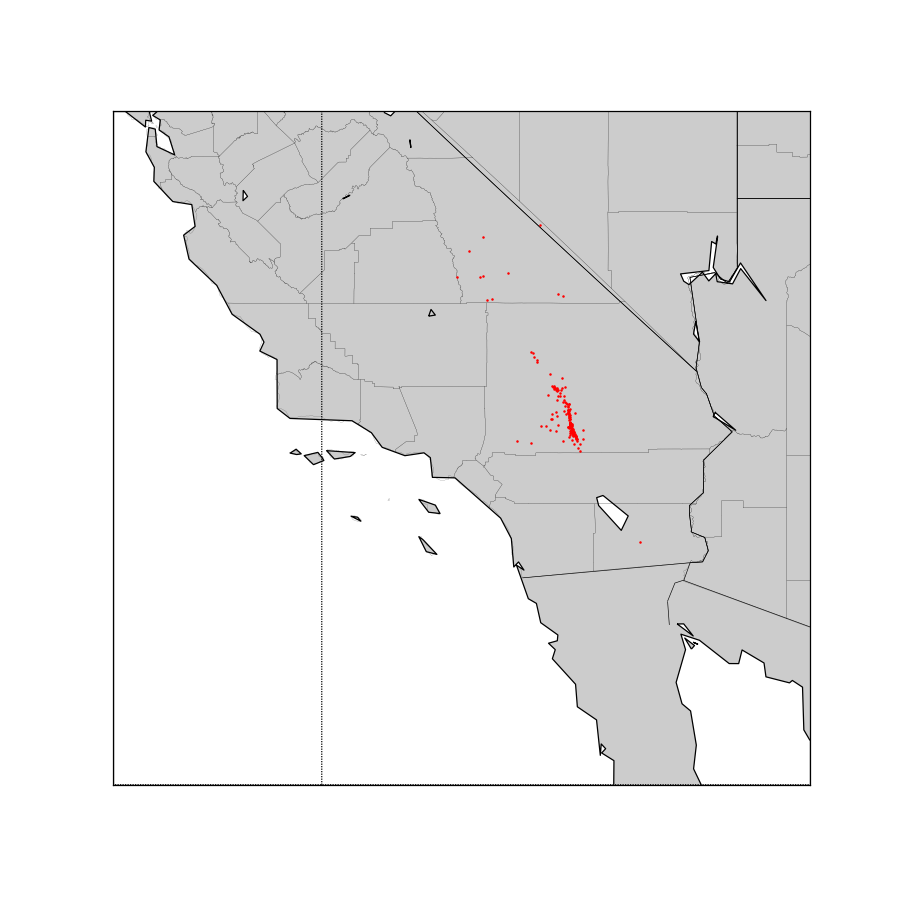

In [97]:
%matplotlib notebook

def progress(i, tot):
    if i % 10 == 0 and i:
        print(f"{i}/{tot}")

matplotlib.rcParams['animation.embed_limit'] = 2**128

fig = plt.figure(figsize=(10,10))

my_map = Basemap(projection='merc', lat_0=34, lon_0=-118,
            resolution='l', area_thresh=10.0,
            llcrnrlon=-123, llcrnrlat=30,
            urcrnrlon=-113, urcrnrlat=38)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents()
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
my_map.drawstates()
my_map.drawcounties()

lons = [df.iloc[i]["Longitude"] for i in l]
lats = [df.iloc[i]["Latitude"] for i in l]

x,y = my_map(lons,lats)

line, = my_map.plot(x[0], y[0], "ro", markersize=1)

def animate(i):
    if i % 50 == 0:
        print(i)
    line.set_data(x[:i],y[:i])
    return [line]

anim = FuncAnimation(fig, animate, frames=1000, interval=5, blit=True)

# from IPython.display import HTML
# HTML(anim.to_jshtml())

# 3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above

The distributions of the waiting times or distances between earthquakes follow a Power Law distribution:

$$
P(t) = A \cdot t^{-B}
$$

This is visualized in log-log scale as a straight line:

$$
\log P(t) = \log A - B\cdot\log t
$$

We can estimate the exponent of the Power Law distribution with a linear fit in the log-log plot, the exponent will be the slope of the straight line.

Select the data for the different values of the minimum magnitude.

In [23]:
def waiting_times(df, m):
    df = copy.deepcopy(df[df["Magnitude"] > m])

    df["Waiting_time"] = df["Time"].diff(periods=1)
    
    return df.dropna()

In [24]:
df_wt2 = waiting_times(df, 2)
df_wt3 = waiting_times(df, 3)
df_wt4 = waiting_times(df, 4)
df_wt5 = waiting_times(df, 5)

wt2 = df_wt2["Waiting_time"]
wt3 = df_wt3["Waiting_time"]
wt4 = df_wt4["Waiting_time"]
wt5 = df_wt5["Waiting_time"]

## 3.1. LINEAR BIN

Plotting histogram with equally spaced binning.

In [25]:
def hist_plot(data,min_xlim,max_xlim,c,m):
    nb = int(c*np.sqrt(len(data)))
    binning = np.linspace(0,np.max(data)*(1+1/10),nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
    
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True,label='Data M >'+str(m) )
    ax1.set_xlabel('Waiting time [s]')
    ax1.set_ylabel('Frequencies')
    ax1.set_xlim(min_xlim,max_xlim)
    ax1.legend()
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)

    plot_log = ax2.plot(bins_center, counts, '.',label='M >'+str(m))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Waiting time [s]')
    ax2.set_ylabel('Frequencies')
    ax2.legend()
    
    fig.tight_layout()
    
    return bins_center,counts

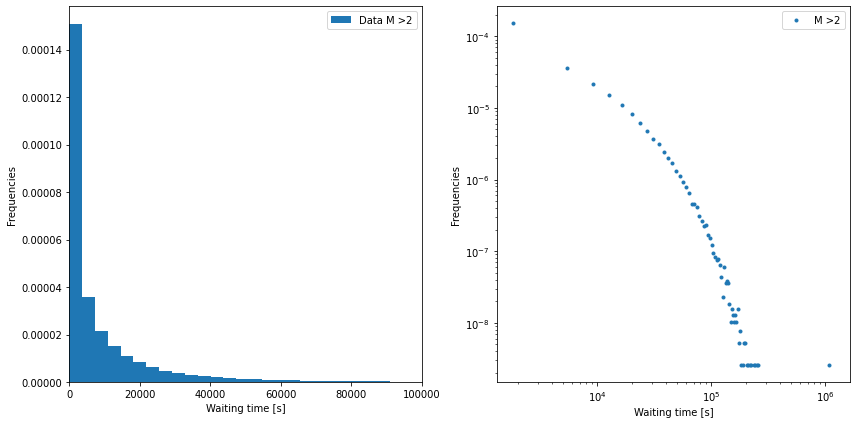

In [26]:
b2,c2 = hist_plot(wt2,0,1e5,1,m=2)

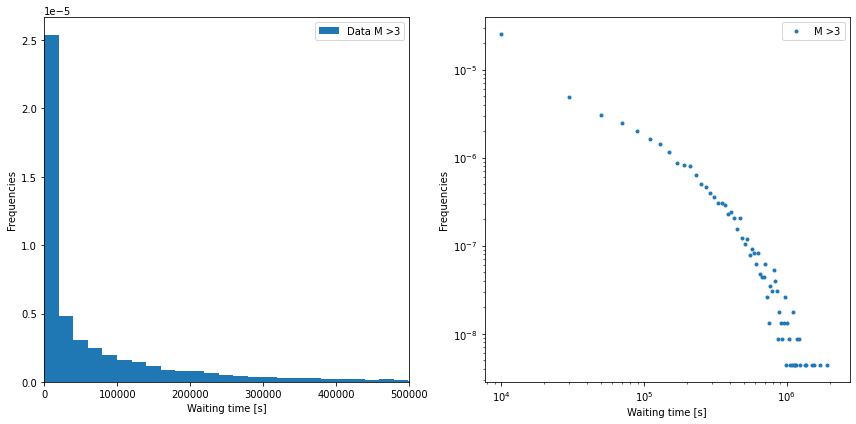

In [27]:
b3,c3 = hist_plot(wt3,0,5e5,1,m=3)

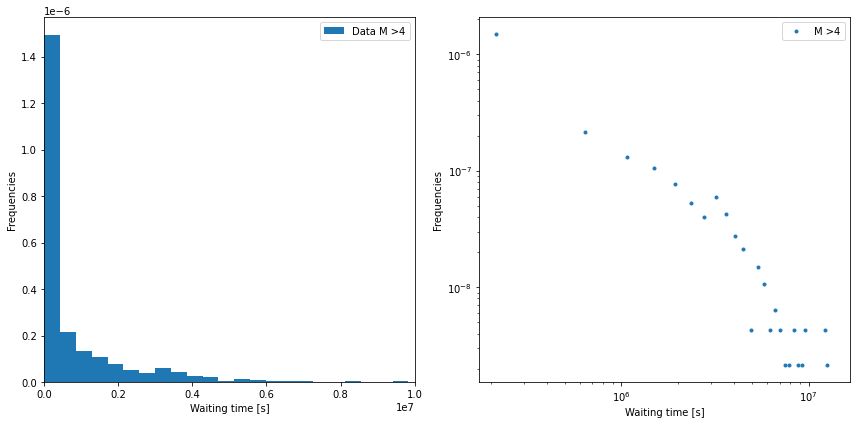

In [28]:
b4,c4 = hist_plot(wt4,0,1e7,1,m=4) 

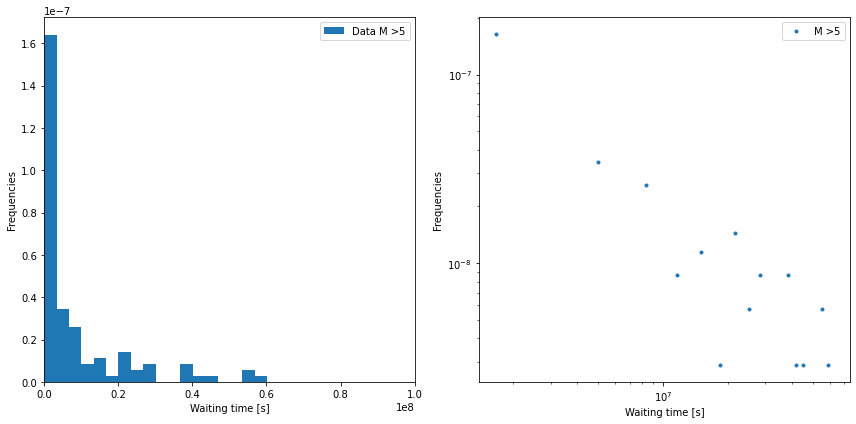

In [29]:
b5,c5 = hist_plot(wt5,0,1e8,2,m=5) 

In the left we can see the shape of the distribution of waiting times. In the right we can see the center of the bins vs counts of the histogram in log-log scale. We note that we have bins with few or zero counts for high waiting times, so we need to define not equally separated bins.
By increasing the number of bins, we can see a smoother distribution and see the same problem of the binning sizes.

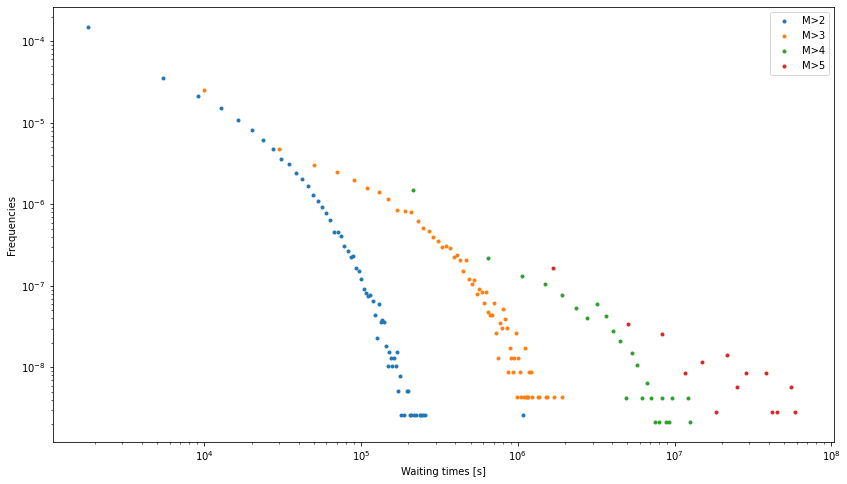

In [30]:
plt.figure(figsize=(14,8))
plt.plot(b2,c2,'.',label='M>2')
plt.plot(b3,c3,'.',label='M>3')
plt.plot(b4,c4,'.',label='M>4')
plt.plot(b5,c5,'.',label='M>5')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Waiting times [s]')
plt.ylabel('Frequencies')
plt.show()

The data for the different values of the minimum magintude are displayed together.

## 3.2. LOG BIN

Plotting histogram with logarithmic binning.

In [31]:
def hist_plot_logbin(data,xlim_max,c,m):
    nb = int(c*np.sqrt(len(data)))
    binning = np.logspace(0,np.log10(np.max(data)*(1+1/10)),nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True,label='M >'+str(m))
    ax1.set_xlim(0,xlim_max)
    ax1.set_xlabel('Waiting time [s]')
    ax1.set_ylabel('Frequencies')
    ax1.legend()
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
        
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)
    counts_abs,bins_edges_abs = np.histogram(data.values,bins=binning,density=False)
    norm_array=sum(counts_abs)*(bins_edges_abs[1:]-bins_edges_abs[:-1])
    
    
    plot_log = ax2.plot(bins_center, counts, '.',label='Data M >'+str(m))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Waiting time [s]')
    ax2.set_ylabel('Frequencies')
    ax2.legend()
    
    fig.tight_layout()
    
    return bins_center,counts,norm_array

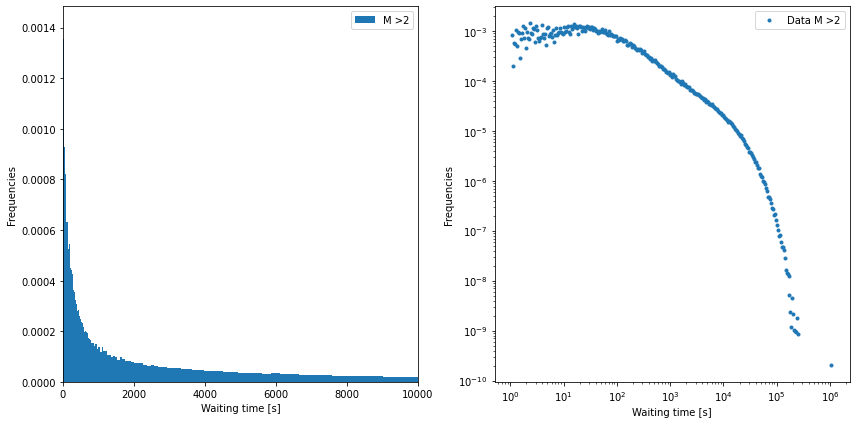

In [32]:
binlog2,countlog2 ,norm2= hist_plot_logbin(wt2,1e4,1,m=2)

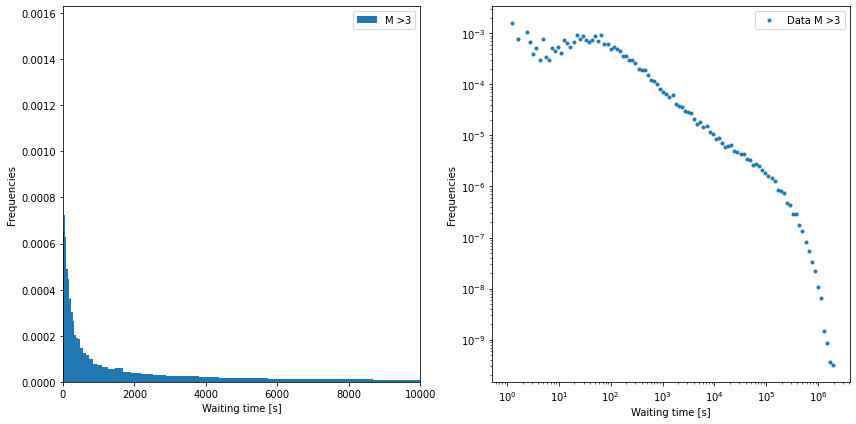

In [33]:
binlog3,countlog3,norm3= hist_plot_logbin(wt3,1e4,1,m=3)

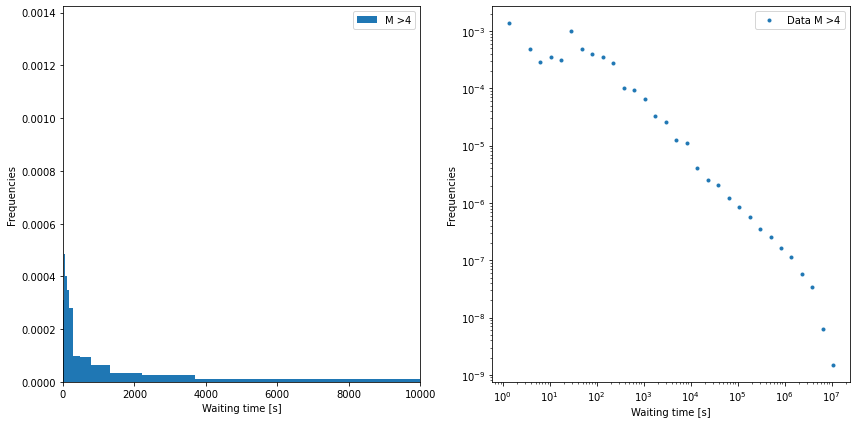

In [34]:
binlog4,countlog4,norm4 = hist_plot_logbin(wt4,1e4,1,m=4)

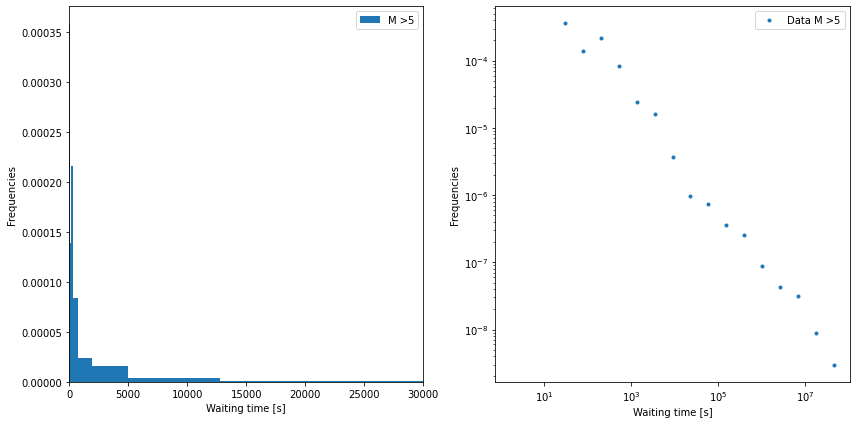

In [35]:
binlog5,countlog5,norm5= hist_plot_logbin(wt5,3e4,2,m=5)

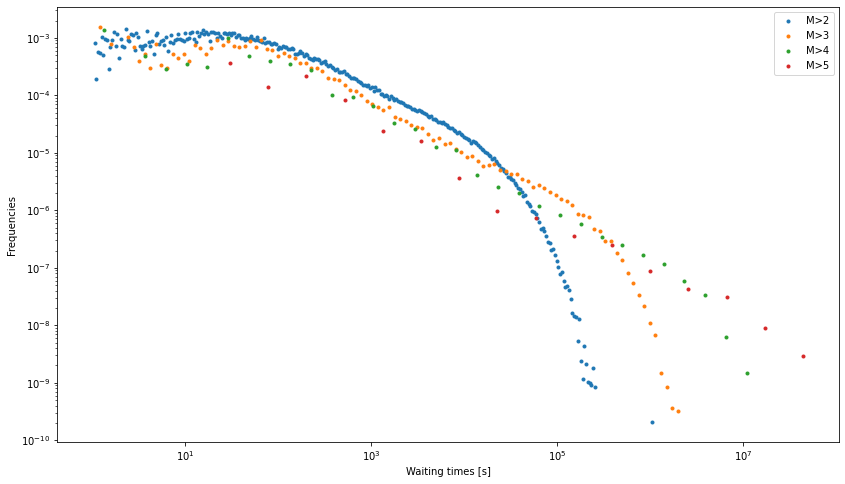

In [36]:
plt.figure(figsize=(14,8)) 
plt.plot(binlog2,countlog2,'.',label='M>2')
plt.plot(binlog3,countlog3,'.',label='M>3')
plt.plot(binlog4,countlog4,'.',label='M>4')
plt.plot(binlog5,countlog5,'.',label='M>5')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Waiting times [s]')
plt.ylabel('Frequencies')
plt.show()

The logaritmic spaced bins properly display the data. We can see on the right plots (log-log scale) a linear region where we can perform a linear fit. In the last plot, all the 4 distribution are displayed together and we can see the linear region appearing in each distribution. For greater waiting times, the data follow an exponential decay.

## 3.3. FIT

Perform linear fit in the linear region. We select this region by considering as many points as possible and staying away from non linear parts, i.e. starting rise and exponential decay.

In [37]:
def fit(bins,count,min,max):
    bins = np.array(bins)
    count = np.array(count)
    x=np.log10(bins[(bins>min) & (bins<max)])
    y=np.log10(count[(bins>min) & (bins<max)])
    fit=stats.linregress(x,y)
    return(fit.slope,10**fit.intercept,fit.stderr,fit.intercept_stderr)

In [38]:
 def linear_fit_plot(bins,counts,norm_array,min_,max_):
    mask=(bins>min_) & (bins<max_)
    erry=np.sqrt(counts[mask]*norm_array[mask])/norm_array[mask]
    x=np.linspace(np.log10(min_),np.log10(max_),10000)
    
    slope,intercept,err_sl,err_int=fit(bins,counts,min_,max_)
    err_line=np.sqrt((x*err_sl)**2+(err_int)**2)
    
    return x,slope,intercept,err_line,mask,erry,bins,counts

In [39]:
fit_wt2=fit(binlog2,countlog2,1e2,1e4)
fit_wt3=fit(binlog3,countlog3,1e2,1e5)
fit_wt4=fit(binlog4,countlog4,5e3,1e6)
fit_wt5=fit(binlog5,countlog5,1e3,1e7)

slope2 = np.round(fit_wt2[0],3)
intercept2 = np.round(np.log10(fit_wt2[1]),2)
err_slope2 = np.round(fit_wt2[2],3)
err_intercept2 = np.round(fit_wt2[3],2)


slope3 = np.round(fit_wt3[0],2)
intercept3 = np.round(np.log10(fit_wt3[1]),2)
err_slope3 = np.round(fit_wt3[2],2)
err_intercept3 = np.round(fit_wt3[3],2)

slope4 = np.round(fit_wt4[0],2)
intercept4 = np.round(np.log10(fit_wt4[1]),1)
err_slope4 = np.round(fit_wt4[2],2)
err_intercept4 = np.round(fit_wt4[3],1)


slope5 = np.round(fit_wt5[0],2)
intercept5 = np.round(np.log10(fit_wt5[1]),1)
err_slope5 = np.round(fit_wt5[2],2)
err_intercept5 = np.round(fit_wt5[3],1)


slopes = [slope2,err_slope2,slope3,err_slope3,slope4,err_slope4,slope5,err_slope5]
intercepts = [intercept2,err_intercept2,intercept3,err_intercept3,intercept4,err_intercept4,intercept5,err_intercept5]

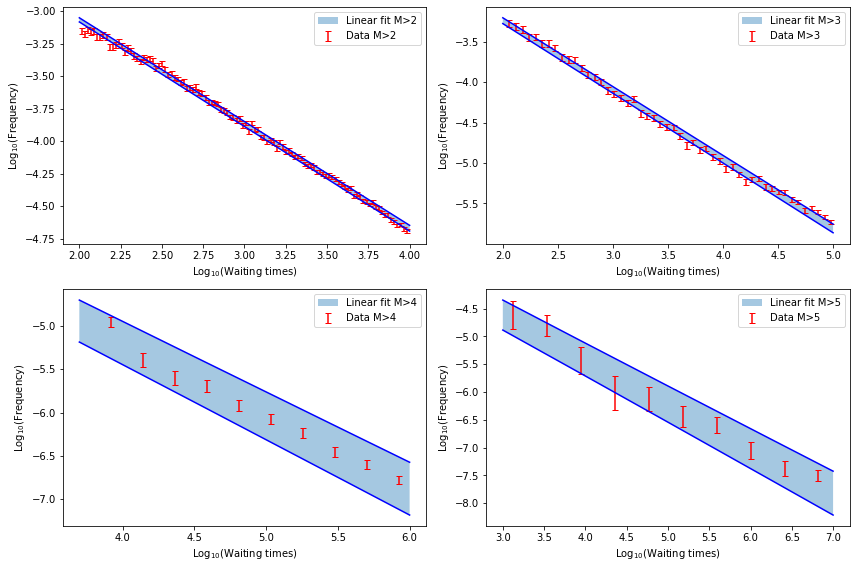

In [40]:
x_1,slope_1,intercept_1,err_line_1,mask_1,erry_1,bins_1,counts_1=linear_fit_plot(binlog2,countlog2,norm2,1e2,1e4)
x_2,slope_2,intercept_2,err_line_2,mask_2,erry_2,bins_2,counts_2=linear_fit_plot(binlog3,countlog3,norm3,1e2,1e5)
x_3,slope_3,intercept_3,err_line_3,mask_3,erry_3,bins_3,counts_3=linear_fit_plot(binlog4,countlog4,norm4,5e3,1e6)
x_4,slope_4,intercept_4,err_line_4,mask_4,erry_4,bins_4,counts_4=linear_fit_plot(binlog5,countlog5,norm5,1e3,1e7)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))


ax1.errorbar(np.log10(bins_1[mask_1]), np.log10(counts_1[mask_1]), 1/np.log(10)*1/counts_1[mask_1]*(erry_1), fmt='None',c='r',capsize=3,label='Data M>2')
ax1.fill_between(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,alpha=0.4,label='Linear fit M>2')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,c='b')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,c='b')

ax1.set_xlabel('Log$_{10}$(Waiting times)')
ax1.set_ylabel('Log$_{10}$(Frequency)')
ax1.legend(loc='best')

ax2.errorbar(np.log10(bins_2[mask_2]), np.log10(counts_2[mask_2]), 1/np.log(10)*1/counts_2[mask_2]*(erry_2), fmt='None',c='r',capsize=3,label='Data M>3')
ax2.fill_between(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,alpha=0.4,label='Linear fit M>3')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,c='b')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,c='b')
ax2.set_xlabel('Log$_{10}$(Waiting times)')
ax2.set_ylabel('Log$_{10}$(Frequency)')
ax2.legend(loc='best')

ax3.errorbar(np.log10(bins_3[mask_3]), np.log10(counts_3[mask_3]), 1/np.log(10)*1/counts_3[mask_3]*(erry_3), fmt='None',c='r',capsize=3,label='Data M>4')
ax3.fill_between(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,alpha=0.4,label='Linear fit M>4')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,c='b')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,c='b')
ax3.set_xlabel('Log$_{10}$(Waiting times)')
ax3.set_ylabel('Log$_{10}$(Frequency)')
ax3.legend(loc='best')

ax4.errorbar(np.log10(bins_4[mask_4]), np.log10(counts_4[mask_4]), 1/np.log(10)*1/counts_4[mask_4]*(erry_4), fmt='None',c='r',capsize=3,label='Data M>5')
ax4.fill_between(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,alpha=0.4,label='Linear fit M>5')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,c='b')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,c='b')
ax4.set_xlabel('Log$_{10}$(Waiting times)')
ax4.set_ylabel('Log$_{10}$(Frequency)')
ax4.legend(loc='best')

fig.tight_layout()

In [41]:
print('The results of the linear fits are: ','\n')
for i in range(0,4):
    print('Slope for fit M >',i+2, ' ', slopes[2*i], '+-', slopes[2*i+1],'   ', 'Intercept for fit M >',i+2, ' ', intercepts[2*i], '+-', intercepts[2*i+1] )

The results of the linear fits are:  

Slope for fit M > 2   -0.801 +- 0.004     Intercept for fit M > 2   -1.47 +- 0.01
Slope for fit M > 3   -0.86 +- 0.01     Intercept for fit M > 3   -1.52 +- 0.03
Slope for fit M > 4   -0.84 +- 0.04     Intercept for fit M > 4   -1.8 +- 0.2
Slope for fit M > 5   -0.8 +- 0.05     Intercept for fit M > 5   -2.2 +- 0.2


We fitted the linear region for each distribution and obtained the parameters of the distributions. The slope is the exponent of the power law. We present a confidence interval for each linear fit.

In [42]:
def f(x,slope,intercept):
    return(intercept*x**slope)

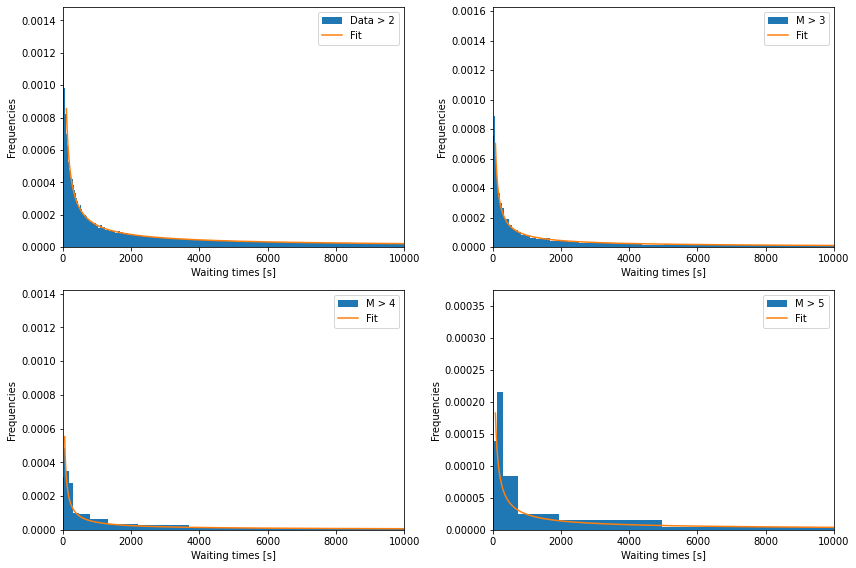

In [43]:
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))

nb =int(np.sqrt(len(wt2)))
counts,bins_edges,patches = ax1.hist(wt2.values,bins=np.logspace(0,np.log10(np.max(wt2)*(1+1/10)),nb),density=True,label='Data > 2')
ax1.set_xlabel('Waiting times [s]')
ax1.set_ylabel('Frequencies')
x=np.linspace(100,10000,int(1e5))
ax1.plot(x,f(x,fit_wt2[0],fit_wt2[1]),label='Fit')
ax1.legend()
ax1.set_xlim(0,1e4)



nb =int(np.sqrt(len(wt3)))
counts,bins_edges,patches = ax2.hist(wt3.values,bins=np.logspace(0,np.log10(np.max(wt3)*(1+1/10)),nb),density=True,label='M > 3')
ax2.set_xlabel('Waiting times [s]')
ax2.set_ylabel('Frequencies')
x=np.linspace(80,10000,int(1e5))
ax2.plot(x,f(x,fit_wt3[0],fit_wt3[1]),label='Fit')
ax2.legend()
ax2.set_xlim(0,1e4)



nb =int(np.sqrt(len(wt4)))
counts,bins_edges,patches = ax3.hist(wt4.values,bins=np.logspace(0,np.log10(np.max(wt4)*(1+1/10)),nb),density=True,label='M > 4')
ax3.set_xlabel('Waiting times [s]')
ax3.set_ylabel('Frequencies')
x=np.linspace(50,10000,int(1e5))
ax3.plot(x,f(x,fit_wt4[0],fit_wt4[1]),label='Fit')
ax3.legend()
ax3.set_xlim(0,1e4)



nb =int(2*np.sqrt(len(wt5)))
counts,bins_edges,patches = ax4.hist(wt5.values,bins=np.logspace(0,np.log10(np.max(wt5)*(1+1/10)),nb),density=True,label='M > 5')
ax4.set_xlabel('Waiting times [s]')
ax4.set_ylabel('Frequencies')
x=np.linspace(80,10000,int(1e5))
ax4.plot(x,f(x,fit_wt5[0],fit_wt5[1]),label='Fit')
ax4.legend()
ax4.set_xlim(0,1e4)


fig.tight_layout()

Here we display the 4 Power Law distribution with logarithmic binning and the fit function.

# 4. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above.

We will follow the same procedure as before.

In [44]:
def distances(df):
    df["Distances"] = np.sqrt((df["X"].diff(periods=1))**2 + (df["Y"].diff(periods=1))**2 + (df["Z"].diff(periods=1))**2)
    return df.dropna()

In [45]:
df_dist2=distances(df_wt2)
df_dist3=distances(df_wt3)
df_dist4=distances(df_wt4)
df_dist5=distances(df_wt5)

dist2 = df_dist2['Distances']
dist3 = df_dist3['Distances']
dist4 = df_dist4['Distances']
dist5 = df_dist5['Distances']

## 4.1. LINEAR BIN

In [46]:
def hist_plot_d(data,xmax,c,m):
    
    nb =int(np.round(c*np.sqrt(len(data))))
    binning = np.linspace(0,np.max(data)*(1+1/10),nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
    
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True,label='M >'+str(m))
    
    ax1.set_xlabel('Distances [m]')
    ax1.set_ylabel('Frequencies')
    ax1.set_xlim(0,xmax)
    ax1.legend()
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)

    plot_log = ax2.plot(bins_center, counts, '.',label='M >'+str(m))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
   
    ax2.set_xlabel('Distances [m]')
    ax2.set_ylabel('Frequencies')
    ax2.legend()
    
    fig.tight_layout()

    return bins_center,counts

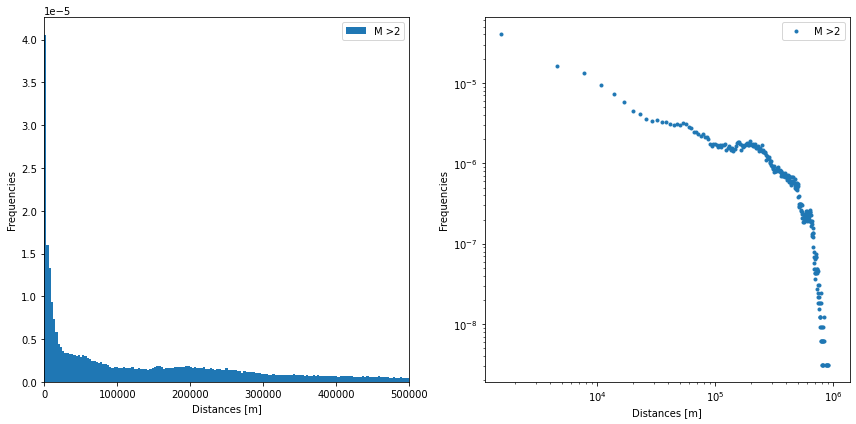

In [47]:
bd2,cd2 = hist_plot_d(dist2,5e5,1,m=2)

We find the same power-law trend with the distances. As expected, we have the same problem as before, we need not equally spaced bins.

## 4.2. LOG BIN

In [48]:
def hist_plot_logbin_d(data,xlim_max,c,m):
    nb =int(np.round(c*np.sqrt(len(data))))
    binning = np.logspace(0,np.log10(np.max(data)*(1+1/10)),nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True,label='M >'+str(m))
    ax1.set_xlim(0,xlim_max)
    ax1.set_xlabel('Distances [m]')
    ax1.set_ylabel('Frequencies')
    ax1.legend()
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
        
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)
    counts_abs,bins_edges_abs = np.histogram(data.values,bins=binning,density=False)
    norm_array=sum(counts_abs)*(bins_edges_abs[1:]-bins_edges_abs[:-1])
    
    
    plot_log = ax2.plot(bins_center, counts, '.',label='M >'+str(m))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Distances [m]')
    ax2.set_ylabel('Frequencies')
    ax2.legend()
    
    fig.tight_layout()
    
    return bins_center,counts,norm_array

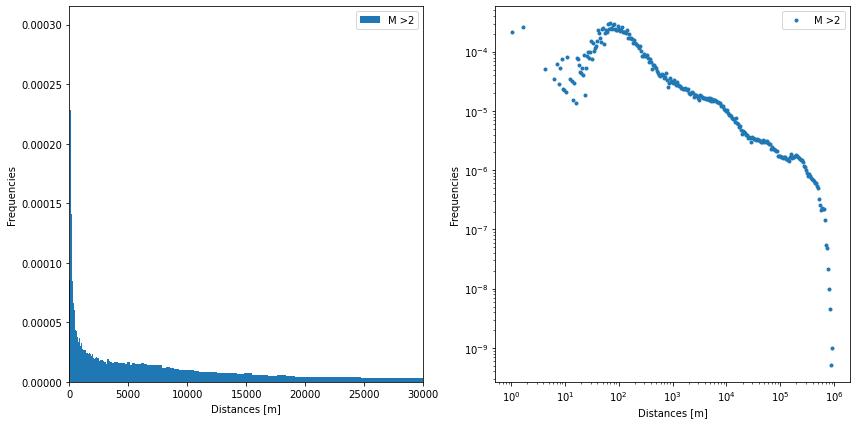

In [49]:
bdl2,cdl2,norm_d2= hist_plot_logbin_d(dist2,3e4,1,m=2)

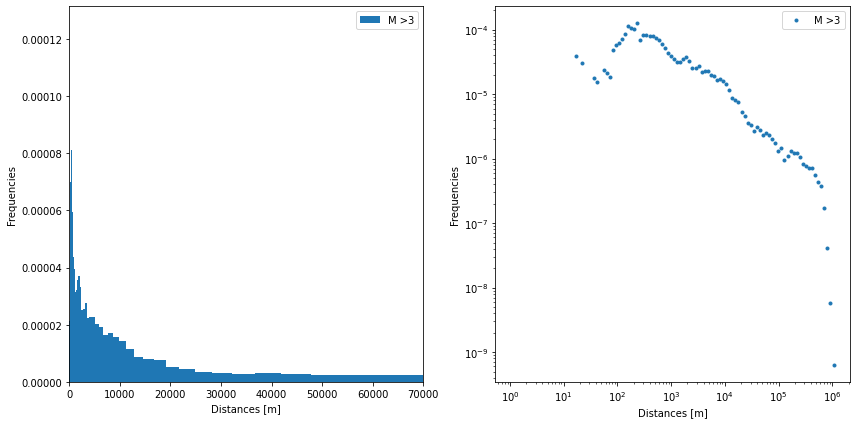

In [50]:
bdl3,cdl3,norm_d3 = hist_plot_logbin_d(dist3,7e4,1,m=3) 

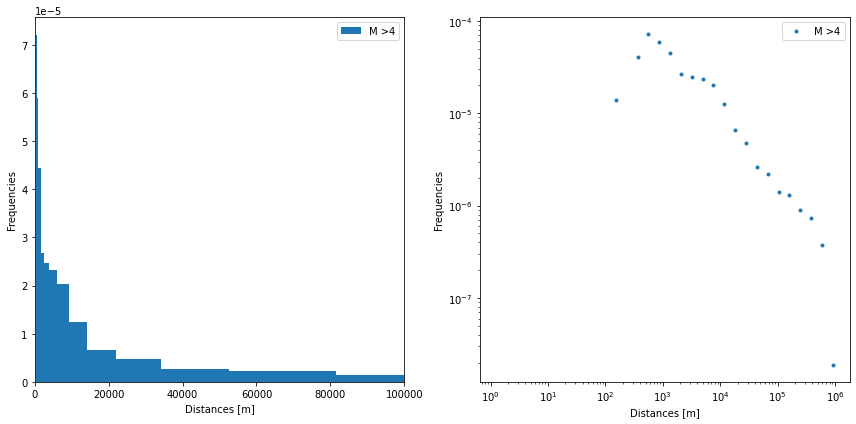

In [51]:
bdl4,cdl4,norm_d4= hist_plot_logbin_d(dist4,1e5,1,m=4) 

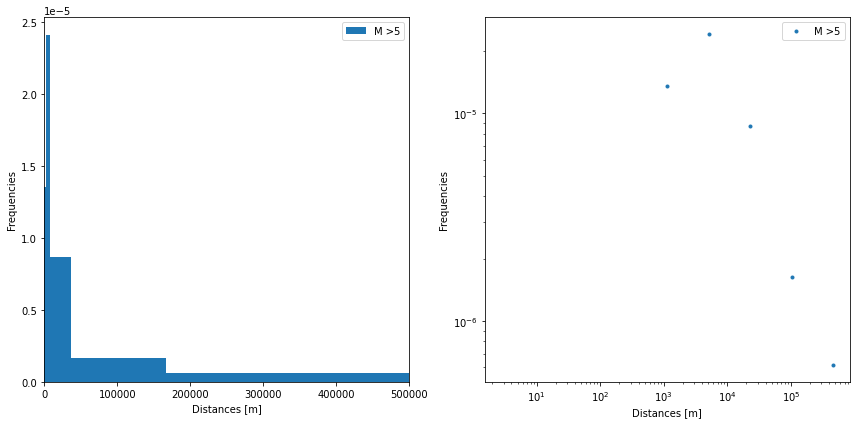

In [52]:
bdl5,cdl5,norm_d5= hist_plot_logbin_d(dist5,5e5,1,m=5)

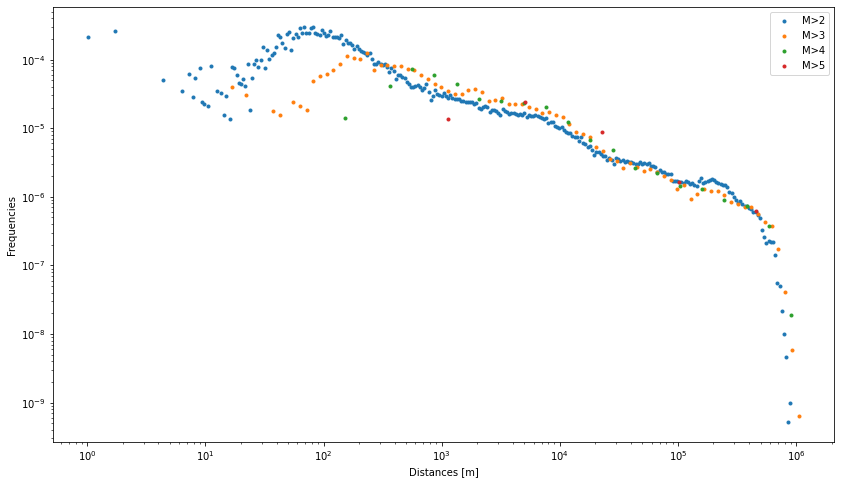

In [53]:
plt.figure(figsize=(14,8)) 
plt.plot(bdl2,cdl2,'.',label='M>2')
plt.plot(bdl3,cdl3,'.',label='M>3')
plt.plot(bdl4,cdl4,'.',label='M>4')
plt.plot(bdl5,cdl5,'.',label='M>5')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Distances [m]')
plt.ylabel('Frequencies')
plt.show()

## 4.3. FIT DISTANCES

In [54]:
max_fit_d=1e5
fit_dist2=fit(bdl2,cdl2,2e2,max_fit_d)
fit_dist3=fit(bdl3,cdl3,1e3,max_fit_d)
fit_dist4=fit(bdl4,cdl4,1.2e3,max_fit_d)
fit_dist5=fit(bdl5,cdl5,5e3,1e6)

slope2 = np.round(fit_dist2[0],2)
intercept2 = np.round(np.log10(fit_dist2[1]),2)
err_slope2 = np.round(fit_dist2[2],2)
err_intercept2 = np.round(fit_dist2[3],2)


slope3 = np.round(fit_dist3[0],2)
intercept3 = np.round(np.log10(fit_dist3[1]),1)
err_slope3 = np.round(fit_dist3[2],2)
err_intercept3 = np.round(fit_dist3[3],1)

slope4 = np.round(fit_dist4[0],2)
intercept4 = np.round(np.log10(fit_dist4[1]),1)
err_slope4 = np.round(fit_dist4[2],2)
err_intercept4 = np.round(fit_dist4[3],1)


slope5 = np.round(fit_dist5[0],2)
intercept5 = np.round(np.log10(fit_dist5[1]),1)
err_slope5 = np.round(fit_dist5[2],2)
err_intercept5 = np.round(fit_dist5[3],1)


slopes = [slope2,err_slope2,slope3,err_slope3,slope4,err_slope4,slope5,err_slope5]
intercepts = [intercept2,err_intercept2,intercept3,err_intercept3,intercept4,err_intercept4,intercept5,err_intercept5]

In [55]:
def linear_fit_plot_d(bins,counts,norm_array,min_,max_):
    mask=(bins>min_) & (bins<max_)
    erry=np.sqrt(counts[mask]*norm_array[mask])/norm_array[mask]
    x=np.linspace(np.log10(min_),np.log10(max_),10000)
    
    slope,intercept,err_sl,err_int=fit(bins,counts,min_,max_)
    err_line=np.sqrt((x*err_sl)**2+(err_int)**2)
    return x,slope,intercept,err_line,mask,erry,bins,counts

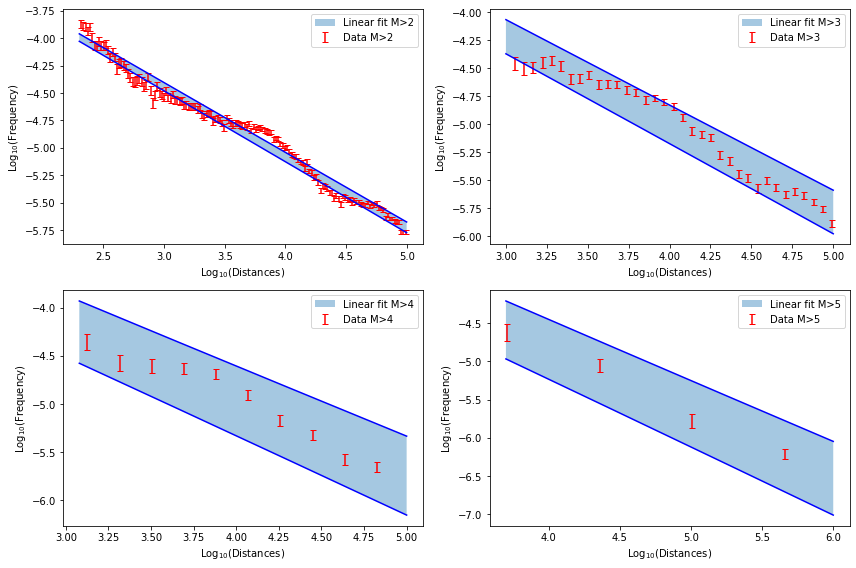

In [56]:
x_1,slope_1,intercept_1,err_line_1,mask_1,erry_1,bins_1,counts_1=linear_fit_plot(bdl2,cdl2,norm_d2,2e2,max_fit_d)
x_2,slope_2,intercept_2,err_line_2,mask_2,erry_2,bins_2,counts_2=linear_fit_plot(bdl3,cdl3,norm_d3,1e3,max_fit_d)
x_3,slope_3,intercept_3,err_line_3,mask_3,erry_3,bins_3,counts_3=linear_fit_plot(bdl4,cdl4,norm_d4,1.2e3,max_fit_d)
x_4,slope_4,intercept_4,err_line_4,mask_4,erry_4,bins_4,counts_4=linear_fit_plot(bdl5,cdl5,norm_d5,5e3,1e6)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))

ax1.errorbar(np.log10(bins_1[mask_1]), np.log10(counts_1[mask_1]), 1/np.log(10)*1/counts_1[mask_1]*(erry_1), fmt='None',c='r',capsize=3,label='Data M>2')
ax1.fill_between(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,alpha=0.4,label='Linear fit M>2')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,c='b')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,c='b')
ax1.set_xlabel('Log$_{10}$(Distances)')
ax1.set_ylabel('Log$_{10}$(Frequency)')
ax1.legend(loc='best')

ax2.errorbar(np.log10(bins_2[mask_2]), np.log10(counts_2[mask_2]), 1/np.log(10)*1/counts_2[mask_2]*(erry_2), fmt='None',c='r',capsize=3,label='Data M>3')
ax2.fill_between(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,alpha=0.4,label='Linear fit M>3')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,c='b')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,c='b')
ax2.set_xlabel('Log$_{10}$(Distances)')
ax2.set_ylabel('Log$_{10}$(Frequency)')
ax2.legend(loc='best')

ax3.errorbar(np.log10(bins_3[mask_3]), np.log10(counts_3[mask_3]), 1/np.log(10)*1/counts_3[mask_3]*(erry_3), fmt='None',c='r',capsize=3,label='Data M>4')
ax3.fill_between(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,alpha=0.4,label='Linear fit M>4')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,c='b')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,c='b')
ax3.set_xlabel('Log$_{10}$(Distances)')
ax3.set_ylabel('Log$_{10}$(Frequency)')
ax3.legend(loc='best')

ax4.errorbar(np.log10(bins_4[mask_4]), np.log10(counts_4[mask_4]), 1/np.log(10)*1/counts_4[mask_4]*(erry_4), fmt='None',c='r',capsize=3,label='Data M>5')
ax4.fill_between(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,alpha=0.4,label='Linear fit M>5')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,c='b')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,c='b')
ax4.set_xlabel('Log$_{10}$(Distances)')
ax4.set_ylabel('Log$_{10}$(Frequency)')
ax4.legend(loc='best')

fig.tight_layout()

In [57]:
print('The results of the linear fits are: ','\n')
for i in range(0,4):
    print('Slope for fit M >',i+2, ' ', slopes[2*i], '+-', slopes[2*i+1],'   ', 'Intercept for fit M >',i+2, ' ', intercepts[2*i], '+-', intercepts[2*i+1] )

The results of the linear fits are:  

Slope for fit M > 2   -0.64 +- 0.01     Intercept for fit M > 2   -2.52 +- 0.03
Slope for fit M > 3   -0.78 +- 0.03     Intercept for fit M > 3   -1.9 +- 0.1
Slope for fit M > 4   -0.78 +- 0.06     Intercept for fit M > 4   -1.9 +- 0.3
Slope for fit M > 5   -0.84 +- 0.06     Intercept for fit M > 5   -1.5 +- 0.3


These are the results of the 4 fits in the linear region for each distribution. Again we estimate the parameter of the linear fit and show an interval in which the fit could be.

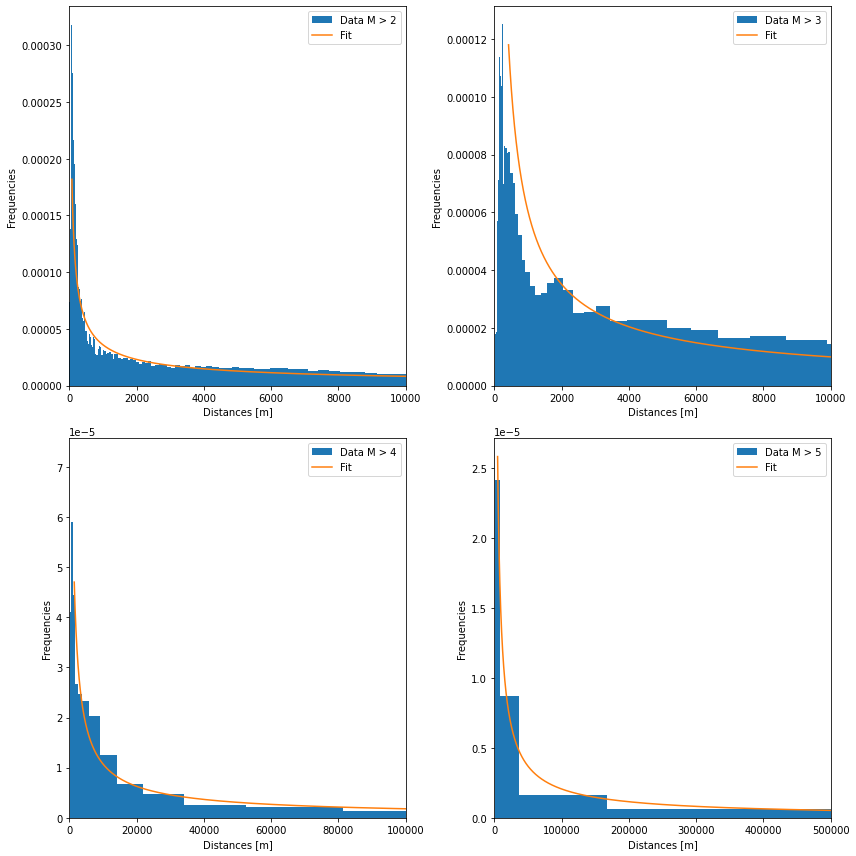

In [58]:
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

nb =int(np.sqrt(len(dist2)))
counts,bins_edges,patches = ax1.hist(dist2.values,bins=np.logspace(0,np.log10(np.max(dist2)*(1+1/10)),nb),density=True,label='Data M > 2')
ax1.set_xlabel('Distances [m]')
ax1.set_ylabel('Frequencies')
x=np.linspace(80,10000,int(1e5))
ax1.plot(x,f(x,fit_dist2[0],fit_dist2[1]),label='Fit')
ax1.set_xlim(0,1e4)
ax1.legend()


nb =int(np.sqrt(len(dist3)))
counts,bins_edges,patches = ax2.hist(dist3.values,bins=np.logspace(0,np.log10(np.max(dist3)*(1+1/10)),nb),density=True,label='Data M > 3')
ax2.set_xlabel('Distances [m]')
ax2.set_ylabel('Frequencies')
x=np.linspace(425,10000,int(1e5))
ax2.plot(x,f(x,fit_dist3[0],fit_dist3[1]),label='Fit')
ax2.legend()

ax2.set_xlim(0,1e4)


nb =int(np.sqrt(len(dist4)))
counts,bins_edges,patches = ax3.hist(dist4.values,bins=np.logspace(0,np.log10(np.max(dist4)*(1+1/10)),nb),density=True,label='Data M > 4')
ax3.set_xlabel('Distances [m]')
ax3.set_ylabel('Frequencies')
x=np.linspace(1500,1000000,int(1e5))
ax3.plot(x,f(x,fit_dist4[0],fit_dist4[1]),label='Fit')
ax3.legend()

ax3.set_xlim(0,1e5)



nb =int(np.sqrt(len(dist5)))
counts,bins_edges,patches = ax4.hist(dist5.values,bins=np.logspace(0,np.log10(np.max(dist5)*(1+1/10)),nb),density=True,label='Data M > 5')
ax4.set_xlabel('Distances [m]')
ax4.set_ylabel('Frequencies')
x=np.linspace(5000,1000000,int(1e4))
ax4.plot(x,f(x,fit_dist5[0],fit_dist5[1]),label='Fit')
ax4.set_xlim(0,5e5)
ax4.legend()

fig.tight_layout()

# 5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$.

We consider R as the average value of the distances between eartquakes with magnitude $>$ 2.

We will follow the same procedure as before.
Now we select the data for different values and bounds on distance.

In [59]:
def mr(datam,c):
    R = np.mean(dist2)
    mr= datam[datam['Distances'] < R/c]['Waiting_time']
    print('Percent of data: ',len(mr)/len(datam)*100, '%')
    return(mr)

In [60]:
mr2_1=mr(df_dist2,1)
mr2_2=mr(df_dist2,10)
mr2_3=mr(df_dist2,80)

Percent of data:  59.696222079927686 %
Percent of data:  26.650721307770535 %
Percent of data:  10.239557045463107 %


In [61]:
mr3_1=mr(df_dist3,1)
mr3_2=mr(df_dist3,10)
mr3_3=mr(df_dist3,80)

Percent of data:  61.522346368715084 %
Percent of data:  32.07925977653631 %
Percent of data:  9.636871508379889 %


In [62]:
mr4_1=mr(df_dist4,1)
mr4_2=mr(df_dist4,10)
mr4_3=mr(df_dist4,80)

Percent of data:  62.841530054644814 %
Percent of data:  32.14936247723133 %
Percent of data:  8.105646630236794 %


In [63]:
mr5_1=mr(df_dist5,1)
mr5_2=mr(df_dist5,10)
mr5_3=mr(df_dist5,80)

Percent of data:  61.165048543689316 %
Percent of data:  25.24271844660194 %
Percent of data:  1.9417475728155338 %


## 5.1. LOG BINS


In [64]:
def hist_plot_5(data_1,data_2,data_3,xlim_max,c1,c2,c3,m):
    %matplotlib inline

    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (12,8))
    
    nb1=int(c1*np.sqrt(len(data_1)))
    binning = np.logspace(0,np.log10(max(data_1)*(1+1/10)),nb1)
    
    counts_1,bins_edges_1,patches_1 = ax1.hist(data_1.values,bins=binning,density=True,label='M >'+str(m))
    ax1.set_title('R')
    ax1.set_xlim(0,xlim_max)
    ax1.set_xlabel('Waiting times [s]')
    ax1.set_ylabel('Frequencies')
    ax1.legend()
    
    
    #counts_abs,bins_edges_abs = np.histogram(data_1.values,bins=binning,density=False)
    #norm_array=sum(counts_abs)*(bins_edges_abs[1:]-bins_edges_abs[:-1]) 
    
    bins_center_1 = 1/2*(bins_edges_1[1:]+bins_edges_1[:-1])        

    plot_log_1 = ax2.plot(bins_center_1, counts_1, '.',label='M >'+str(m))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('R')
    ax2.set_xlabel('Waiting times [s]')
    ax2.set_ylabel('Frequencies')
    ax2.legend()

    nb2=int(c2*np.sqrt(len(data_2)))
    binning = np.logspace(0,np.log10(max(data_2)*(1+1/10)),nb2)    

    counts_2,bins_edges_2,patches_2 = ax3.hist(data_2.values,bins=binning,density=True,label='M >'+str(m))
    ax3.set_title('R/10')
    ax3.set_xlim(0,xlim_max)
    ax3.set_xlabel('Waiting times [s]')
    ax3.set_ylabel('Frequencies')
    ax3.legend()
    
    counts_abs,bins_edges_abs = np.histogram(data_2.values,bins=binning,density=False)
    norm_array=sum(counts_abs)*(bins_edges_abs[1:]-bins_edges_abs[:-1]) 
    
    bins_center_2 = 1/2*(bins_edges_2[1:]+bins_edges_2[:-1])
        

    plot_log_2 = ax4.plot(bins_center_2, counts_2, '.',label='M >'+str(m))
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title('R/10')
    ax4.set_xlabel('Waiting times [s]')
    ax4.set_ylabel('Frequencies')
    ax4.legend()
    
    
    nb3=int(c3*np.sqrt(len(data_3)))
    binning = np.logspace(0,np.log10(max(data_3)*(1+1/10)),nb3)

    counts_3,bins_edges_3,patches_3 = ax5.hist(data_3.values,bins=binning,density=True,label='M >'+str(m))
    ax5.set_title('R/100')
    ax5.set_xlim(0,xlim_max)
    ax5.set_xlabel('Waiting times [s]')
    ax5.set_ylabel('Frequencies')
    ax5.legend()
    
    
    #counts_abs,bins_edges_abs = np.histogram(data_3.values,bins=binning,density=False)
    #norm_array=sum(counts_abs)*(bins_edges_abs[1:]-bins_edges_abs[:-1]) 
    
    bins_center_3 =  1/2*(bins_edges_3[1:]+bins_edges_3[:-1])
        
    
    plot_log_3 = ax6.plot(bins_center_3, counts_3, '.',label='M >'+str(m))
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.set_title('R/100')
    ax6.set_xlabel('Waiting times [s]')
    ax6.set_ylabel('Frequencies')
    ax6.legend()
    
    
    fig.tight_layout()
    
    return bins_center_1,counts_1, bins_center_2, counts_2, bins_center_3, counts_3, norm_array

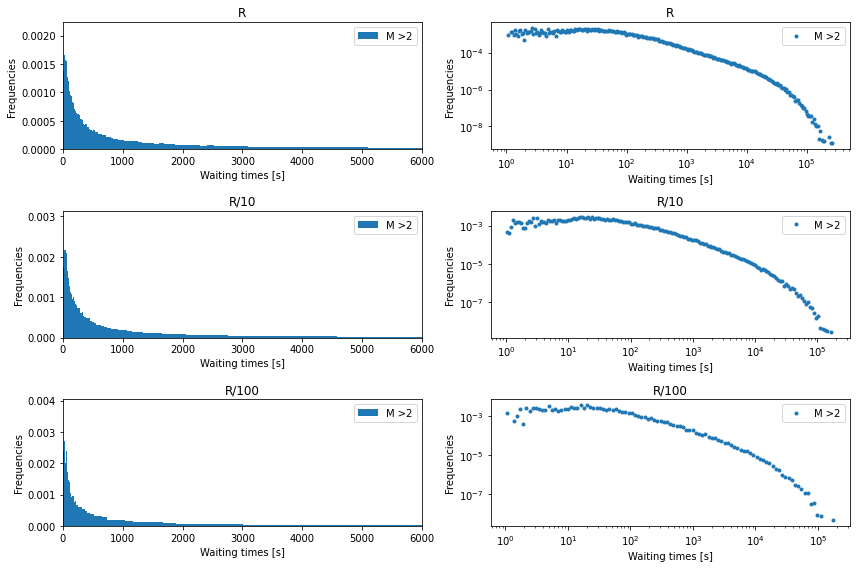

In [65]:
data_mr_2 = hist_plot_5(mr2_1,mr2_2,mr2_3,6e3,1,1,1,m=2)

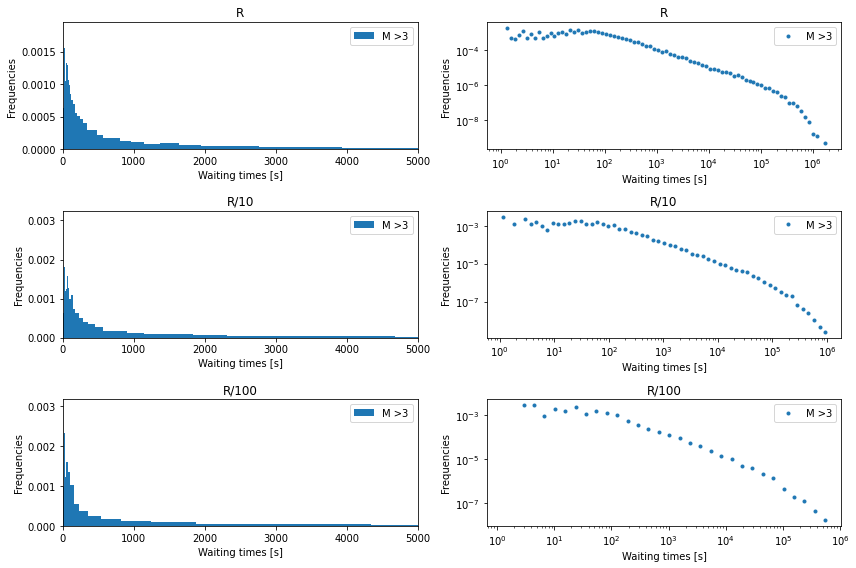

In [66]:
data_mr_3 = hist_plot_5(mr3_1,mr3_2,mr3_3,5e3,1,1,1,m=3)

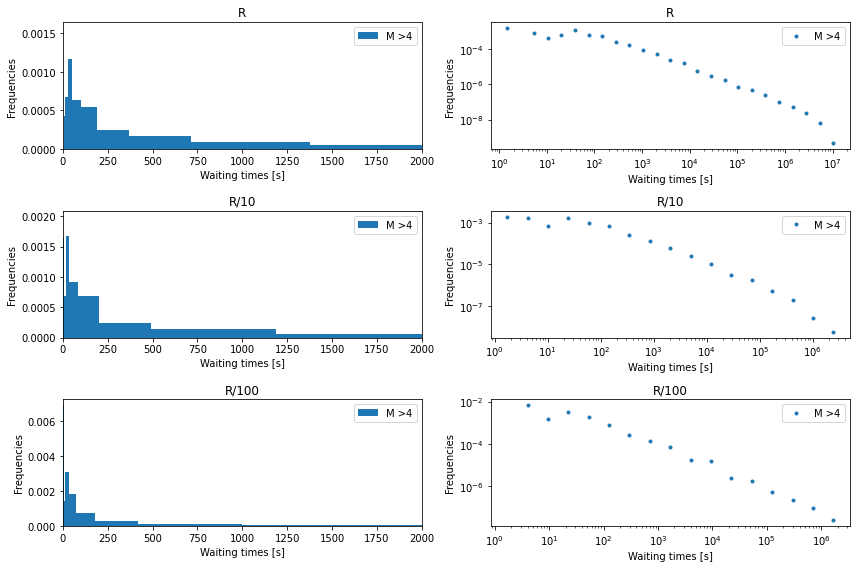

In [67]:
data_mr_4 = hist_plot_5(mr4_1,mr4_2,mr4_3,2e3,1,1,2,m=4)

In [68]:
data_mr_5 =hist_plot_5(mr5_1,mr5_2,mr5_3,2e4,3,4,2,m=5)
plt.close() #R/100 data contain only 1 point, so we don't show the plot

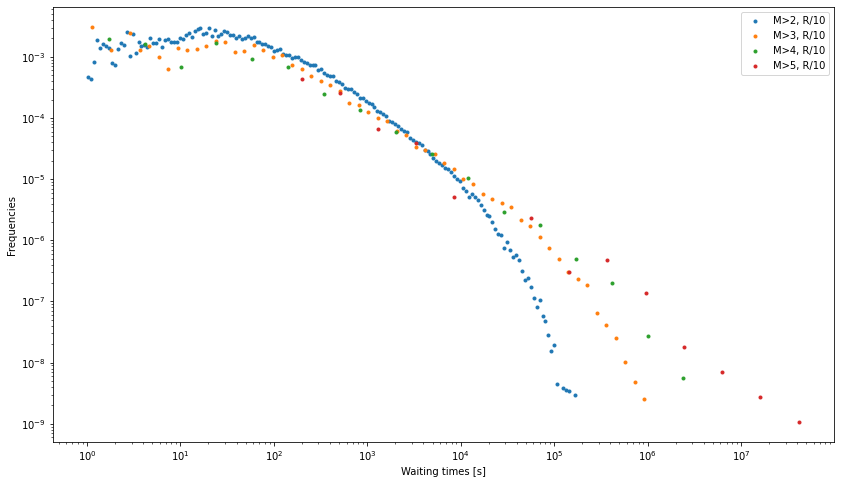

In [69]:
plt.figure(figsize=(14,8)) 
plt.plot(data_mr_2[2],data_mr_2[3],'.',label='M>2, R/10')
plt.plot(data_mr_3[2],data_mr_3[3],'.',label='M>3, R/10')
plt.plot(data_mr_4[2],data_mr_4[3],'.',label='M>4, R/10')
plt.plot(data_mr_5[2],data_mr_5[3],'.',label='M>5, R/10') 

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Waiting times [s]')
plt.ylabel('Frequencies')
plt.show()

This plot shows the different shapes (center of the bins vs counts) of the distributions for different magnitude thresholds with R/10 in log-log scales.

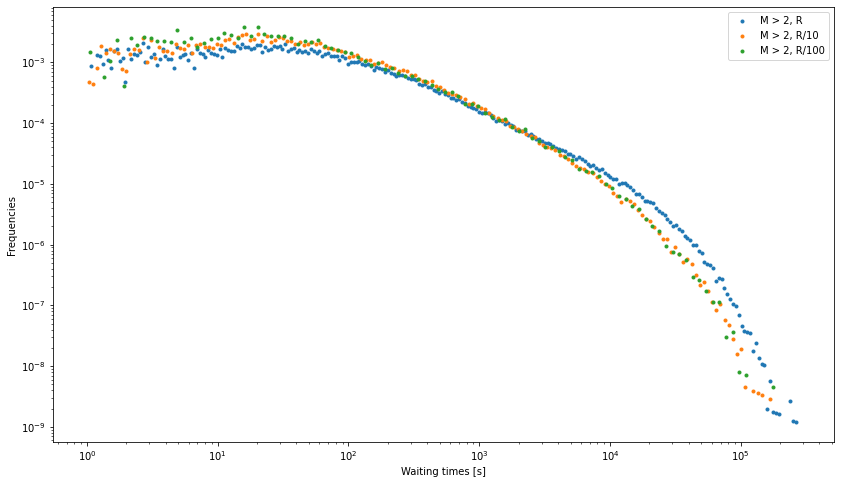

In [70]:
labels=['R','R/10','R/100']
plt.figure(figsize=(14,8))
for i in range(3):
    j=2*i
    plt.plot(data_mr_2[j],data_mr_2[j+1],'.', label='M > 2, '+labels[i])
    #plt.plot(data_mr_3[j],data_mr_3[j+1],'.', label='M > 3, '+labels[i])
    #plt.plot(data_mr_4[j],data_mr_4[j+1],'.', label='M > 4, '+labels[i])
    #plt.plot(data_mr_5[j],data_mr_5[j+1],'.', label='M > 5, '+labels[i])
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Waiting times [s]')
    plt.ylabel('Frequencies')
    plt.legend(loc='best')

Instead here we can see the different shapes (center of the bins vs counts) for each magnitude thresholds and different R values (R, R/10, R/100). By removing the comments in the above cell, we can display all the distributions, for each magnitude threshold and each R values.

## 5.2 FIT

Perform linear fit onyl for value R/10.

In [71]:
#Remove the zero counts for M > 5 (error in displaying plots)

cmr_5=data_mr_5[3]
bmr_5=data_mr_5[2]
norm_mr5=data_mr_5[-1]
cmr_5_notzero = cmr_5[cmr_5 != 0]
bmr_5_notzero = bmr_5[cmr_5 != 0]
norm_mr5_notzero = norm_mr5[cmr_5 != 0]

In [72]:
fit_mr2=fit(data_mr_2[2],data_mr_2[3],1e2,1e4)
fit_mr3=fit(data_mr_3[2],data_mr_3[3],2e2,2e4)
fit_mr4=fit(data_mr_4[2],data_mr_4[3],2e2,1e5)
fit_mr5=fit(bmr_5_notzero,cmr_5_notzero,1e3,1e7)

slope2 = np.round(fit_mr2[0],3)
intercept2 = np.round(np.log10(fit_mr2[1]),3)
err_slope2 = np.round(fit_mr2[2],3)
err_intercept2 = np.round(fit_mr2[3],3)


slope3 = np.round(fit_mr3[0],3)
intercept3 = np.round(np.log10(fit_mr3[1]),3)
err_slope3 = np.round(fit_mr3[2],3)
err_intercept3 = np.round(fit_mr3[3],3)

slope4 = np.round(fit_mr4[0],3)
intercept4 = np.round(np.log10(fit_mr4[1]),3)
err_slope4 = np.round(fit_mr4[2],3)
err_intercept4 = np.round(fit_mr4[3],3)


slope5 = np.round(fit_mr5[0],3)
intercept5 = np.round(np.log10(fit_mr5[1]),3)
err_slope5 = np.round(fit_mr5[2],3)
err_intercept5 = np.round(fit_mr5[3],3)


slopes = [slope2,err_slope2,slope3,err_slope3,slope4,err_slope4,slope5,err_slope5]
intercepts = [intercept2,err_intercept2,intercept3,err_intercept3,intercept4,err_intercept4,intercept5,err_intercept5]

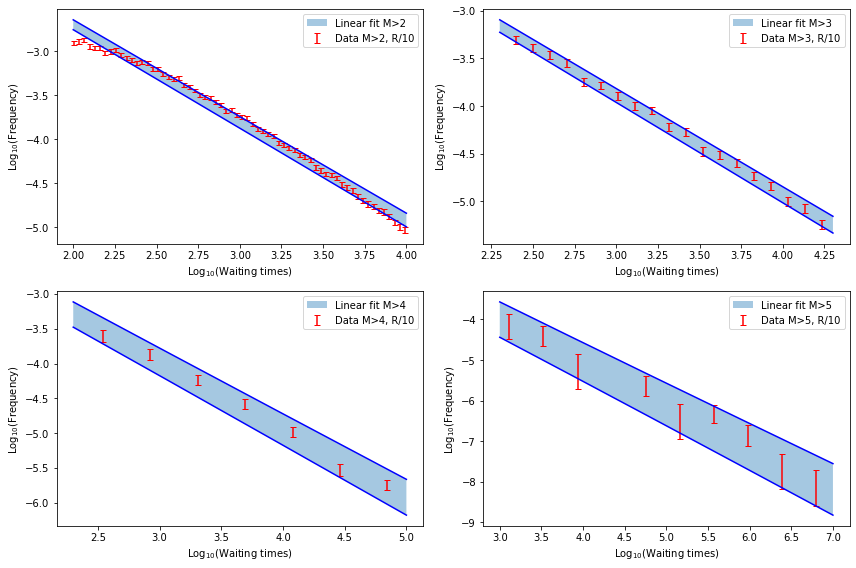

In [73]:
x_1,slope_1,intercept_1,err_line_1,mask_1,erry_1,bins_1,counts_1=linear_fit_plot(data_mr_2[2],data_mr_2[3],data_mr_2[-1],1e2,1e4)
x_2,slope_2,intercept_2,err_line_2,mask_2,erry_2,bins_2,counts_2=linear_fit_plot(data_mr_3[2],data_mr_3[3],data_mr_3[-1],2e2,2e4)
x_3,slope_3,intercept_3,err_line_3,mask_3,erry_3,bins_3,counts_3=linear_fit_plot(data_mr_4[2],data_mr_4[3],data_mr_4[-1],2e2,1e5)
x_4,slope_4,intercept_4,err_line_4,mask_4,erry_4,bins_4,counts_4=linear_fit_plot(bmr_5_notzero,cmr_5_notzero,norm_mr5_notzero,1e3,1e7)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))

ax1.errorbar(np.log10(bins_1[mask_1]), np.log10(counts_1[mask_1]), 1/np.log(10)*1/counts_1[mask_1]*(erry_1), fmt='None',c='r',capsize=3,label='Data M>2, R/10')
ax1.fill_between(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,alpha=0.4,label='Linear fit M>2')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,c='b')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,c='b')
ax1.set_xlabel('Log$_{10}$(Waiting times)')
ax1.set_ylabel('Log$_{10}$(Frequency)')
ax1.legend(loc='best')

ax2.errorbar(np.log10(bins_2[mask_2]), np.log10(counts_2[mask_2]), 1/np.log(10)*1/counts_2[mask_2]*(erry_2), fmt='None',c='r',capsize=3,label='Data M>3, R/10')
ax2.fill_between(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,alpha=0.4,label='Linear fit M>3')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,c='b')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,c='b')
ax2.set_xlabel('Log$_{10}$(Waiting times)')
ax2.set_ylabel('Log$_{10}$(Frequency)')
ax2.legend(loc='best')

ax3.errorbar(np.log10(bins_3[mask_3]), np.log10(counts_3[mask_3]), 1/np.log(10)*1/counts_3[mask_3]*(erry_3), fmt='None',c='r',capsize=3,label='Data M>4, R/10')
ax3.fill_between(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,alpha=0.4,label='Linear fit M>4')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,c='b')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,c='b')
ax3.set_xlabel('Log$_{10}$(Waiting times)')
ax3.set_ylabel('Log$_{10}$(Frequency)')
ax3.legend(loc='best')

ax4.errorbar(np.log10(bins_4[mask_4]), np.log10(counts_4[mask_4]), 1/np.log(10)*1/counts_4[mask_4]*(erry_4), fmt='None',c='r',capsize=3,label='Data M>5, R/10')
ax4.fill_between(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,alpha=0.4,label='Linear fit M>5')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,c='b')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,c='b')
ax4.set_xlabel('Log$_{10}$(Waiting times)')
ax4.set_ylabel('Log$_{10}$(Frequency)')
ax4.legend(loc='best')

fig.tight_layout()

In [74]:
print('The results of the linear fits are: ','\n')
for i in range(0,4):
    print('Slope for fit M >',i+2, ' ', slopes[2*i], '+-', slopes[2*i+1],'   ', 'Intercept for fit M >',i+2, ' ', intercepts[2*i], '+-', intercepts[2*i+1] )

The results of the linear fits are:  

Slope for fit M > 2   -1.108 +- 0.015     Intercept for fit M > 2   -0.486 +- 0.047
Slope for fit M > 3   -1.041 +- 0.016     Intercept for fit M > 3   -0.766 +- 0.054
Slope for fit M > 4   -0.973 +- 0.041     Intercept for fit M > 4   -1.058 +- 0.155
Slope for fit M > 5   -1.048 +- 0.073     Intercept for fit M > 5   -0.86 +- 0.378


We present the fit and the estimated parameters of the distribution in the case of R=10. The slope of the linear fit has increased w.r.t. the previous fits on waiting times. This means that closer earthquakes tend to have smaller waiting times.

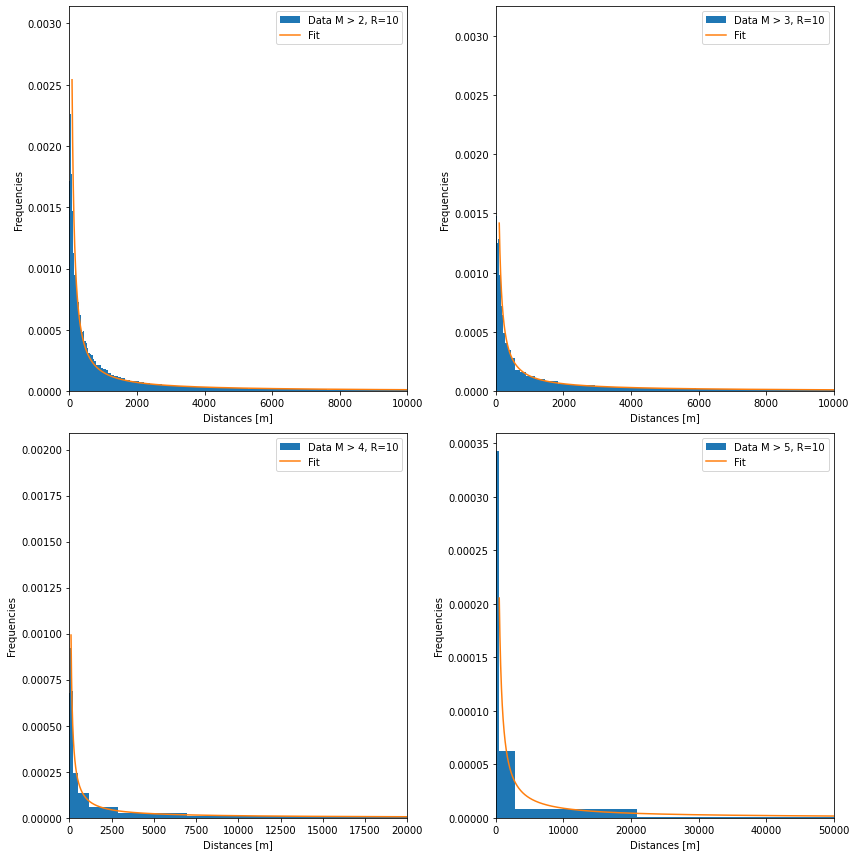

In [75]:
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

nb =int(np.sqrt(len(mr2_2)))
counts,bins_edges,patches = ax1.hist(mr2_2.values,bins=np.logspace(0,np.log10(np.max(mr2_2)*(1+1/10)),nb),density=True,label='Data M > 2, R=10')
ax1.set_xlabel('Distances [m]')
ax1.set_ylabel('Frequencies')
x=np.linspace(80,10000,int(1e5))
ax1.plot(x,f(x,fit_mr2[0],fit_mr2[1]),label='Fit')
ax1.set_xlim(0,1e4)
ax1.legend()


nb =int(np.sqrt(len(mr3_2)))
counts,bins_edges,patches = ax2.hist(mr3_2.values,bins=np.logspace(0,np.log10(np.max(mr3_2)*(1+1/10)),nb),density=True,label='Data M > 3, R=10')
ax2.set_xlabel('Distances [m]')
ax2.set_ylabel('Frequencies')
x=np.linspace(100,10000,int(1e5))
ax2.plot(x,f(x,fit_mr3[0],fit_mr3[1]),label='Fit')
ax2.legend()
ax2.set_xlim(0,1e4)


nb =int(np.sqrt(len(mr4_2)))
counts,bins_edges,patches = ax3.hist(mr4_2.values,bins=np.logspace(0,np.log10(np.max(mr4_2)*(1+1/10)),nb),density=True,label='Data M > 4, R=10')
ax3.set_xlabel('Distances [m]')
ax3.set_ylabel('Frequencies')
x=np.linspace(100,1000000,int(1e5))
ax3.plot(x,f(x,fit_mr4[0],fit_mr4[1]),label='Fit')
ax3.legend()
ax3.set_xlim(0,2e4)



nb =int(2*np.sqrt(len(mr5_2)))
counts,bins_edges,patches = ax4.hist(mr5_2.values,bins=np.logspace(0,np.log10(np.max(mr5_2)*(1+1/10)),nb),density=True,label='Data M > 5, R=10')
ax4.set_xlabel('Distances [m]')
ax4.set_ylabel('Frequencies')
x=np.linspace(500,100000,int(1e4))
ax4.plot(x,f(x,fit_mr5[0],fit_mr5[1]),label='Fit')
ax4.set_xlim(0,5e4)
ax4.legend()

fig.tight_layout()

We observe again the Power Law distribution shape. 

# 6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture.

## 6.1. Rescaling results in section 3

We rescale the values by the average value of each dataset. Then we follow the same procedure.

In [76]:
wt2_r = wt2/np.mean(wt2)
wt3_r = wt3/np.mean(wt3)
wt4_r = wt4/np.mean(wt4)
wt5_r = wt5/np.mean(wt5)

In [77]:
def hist_plot_logbin_mean(data,min_log,xlim_max,c,m):
    nb = int(c*np.sqrt(len(data)))
    binning = np.logspace(min_log,np.log10(np.max(data)*(1+1/10)),nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True,label='M >'+str(m))
    ax1.set_xlim(0,xlim_max)
    ax1.set_xlabel('Waiting time [s]')
    ax1.set_ylabel('Frequencies')
    ax1.legend()
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
        
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)
    counts_abs,bins_edges_abs = np.histogram(data.values,bins=binning,density=False)
    norm_array=sum(counts_abs)*(bins_edges_abs[1:]-bins_edges_abs[:-1])
    
    
    plot_log = ax2.plot(bins_center, counts, '.',label='M >'+str(m))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Waiting time [s]')
    ax2.set_ylabel('Frequencies')
    ax2.legend()
    
    fig.tight_layout()
    
    return bins_center,counts,norm_array

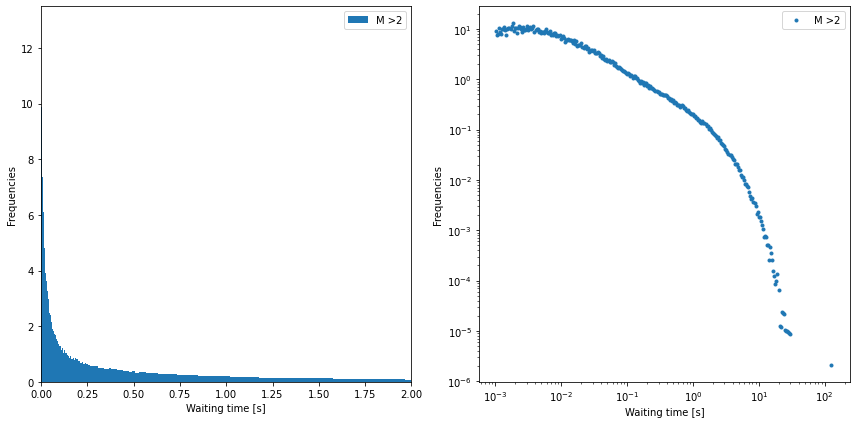

In [78]:
blr2,clr2,norm_r2 = hist_plot_logbin_mean(wt2_r,-3,2,1,m=2)

In [79]:
blr3,clr3,norm_r3 = hist_plot_logbin_mean(wt3_r,-3,0.5,1,m=3)
blr4,clr4,norm_r4 = hist_plot_logbin_mean(wt4_r,-3,0.2,1,m=4)
blr5,clr5,norm_r5 = hist_plot_logbin_mean(wt5_r,-3,2,1,m=5)
plt.close()

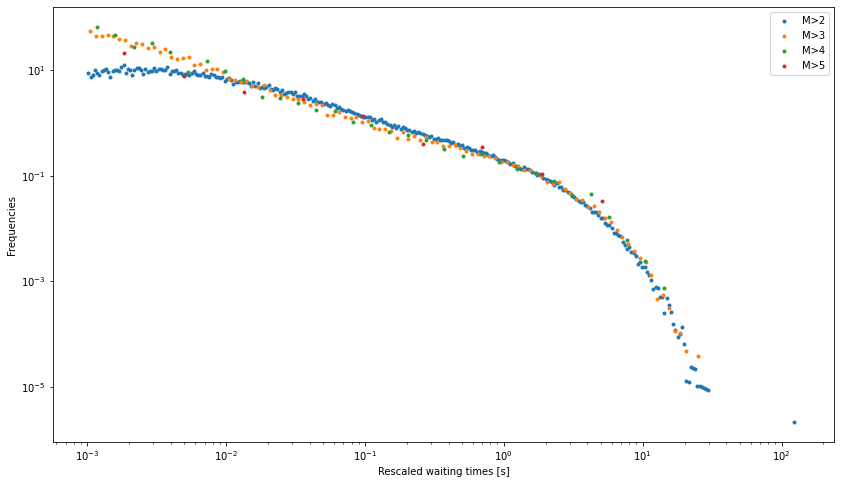

In [80]:
plt.figure(figsize=(14,8)) 
plt.plot(blr2,clr2,'.',label='M>2')
plt.plot(blr3,clr3,'.',label='M>3')
plt.plot(blr4,clr4,'.',label='M>4')
plt.plot(blr5,clr5,'.',label='M>5')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Rescaled waiting times [s]')
plt.ylabel('Frequencies')
plt.show()

By rescaling the data, we obtain that all the functions collapse into one. The linear part of the graph, which represents the Power Law distribution,  is clearly visible, and it is followed by an exponential decay. This means that all the samples of data, differentiated by values of magnitude, behave in the same way (as shown in the previous assignement. We can note that all the distributions collapse also in the exponential decay.

## Fit

In [81]:
fit_wt_r2=fit(blr2,clr2,1e-2,1e0)
fit_wt_r3=fit(blr3,clr3,1e-2,1e0)
fit_wt_r4=fit(blr4,clr4,1e-2,1e0)
fit_wt_r5=fit(blr5,clr5,1e-2,1e0)

slope2 = np.round(fit_wt_r2[0],3)
intercept2 = np.round(np.log10(fit_wt_r2[1]),3)
err_slope2 = np.round(fit_wt_r2[2],3)
err_intercept2 = np.round(fit_wt_r2[3],3)


slope3 = np.round(fit_wt_r3[0],2)
intercept3 = np.round(np.log10(fit_wt_r3[1]),2)
err_slope3 = np.round(fit_wt_r3[2],2)
err_intercept3 = np.round(fit_wt_r3[3],2)

slope4 = np.round(fit_wt_r4[0],2)
intercept4 = np.round(np.log10(fit_wt_r4[1]),2)
err_slope4 = np.round(fit_wt_r4[2],2)
err_intercept4 = np.round(fit_wt_r4[3],2)


slope5 = np.round(fit_wt_r5[0],1)
intercept5 = np.round(np.log10(fit_wt_r5[1]),1)
err_slope5 = np.round(fit_wt_r5[2],1)
err_intercept5 = np.round(fit_wt_r5[3],1)


slopes = [slope2,err_slope2,slope3,err_slope3,slope4,err_slope4,slope5,err_slope5]
intercepts = [intercept2,err_intercept2,intercept3,err_intercept3,intercept4,err_intercept4,intercept5,err_intercept5]

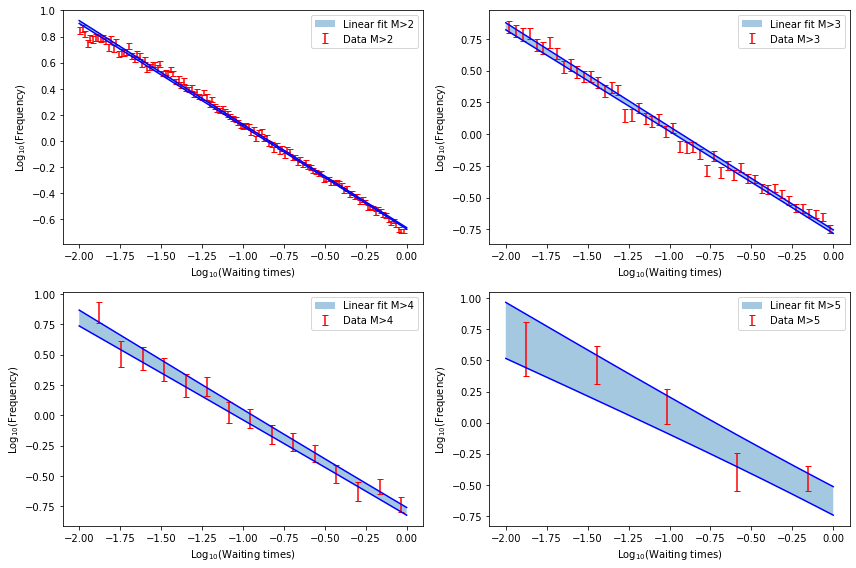

In [82]:
x_1,slope_1,intercept_1,err_line_1,mask_1,erry_1,bins_1,counts_1=linear_fit_plot(blr2,clr2,norm_r2,1e-2,1e0)
x_2,slope_2,intercept_2,err_line_2,mask_2,erry_2,bins_2,counts_2=linear_fit_plot(blr3,clr3,norm_r3,1e-2,1e0)
x_3,slope_3,intercept_3,err_line_3,mask_3,erry_3,bins_3,counts_3=linear_fit_plot(blr4,clr4,norm_r4,1e-2,1e0)
x_4,slope_4,intercept_4,err_line_4,mask_4,erry_4,bins_4,counts_4=linear_fit_plot(blr5,clr5,norm_r5,1e-2,1e0)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))

ax1.errorbar(np.log10(bins_1[mask_1]), np.log10(counts_1[mask_1]), 1/np.log(10)*1/counts_1[mask_1]*(erry_1), fmt='None',c='r',capsize=3,label='Data M>2')
ax1.fill_between(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,alpha=0.4,label='Linear fit M>2')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,c='b')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,c='b')
ax1.set_xlabel('Log$_{10}$(Waiting times)')
ax1.set_ylabel('Log$_{10}$(Frequency)')
ax1.legend(loc='best')

ax2.errorbar(np.log10(bins_2[mask_2]), np.log10(counts_2[mask_2]), 1/np.log(10)*1/counts_2[mask_2]*(erry_2), fmt='None',c='r',capsize=3,label='Data M>3')
ax2.fill_between(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,alpha=0.4,label='Linear fit M>3')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,c='b')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,c='b')
ax2.set_xlabel('Log$_{10}$(Waiting times)')
ax2.set_ylabel('Log$_{10}$(Frequency)')
ax2.legend(loc='best')

ax3.errorbar(np.log10(bins_3[mask_3]), np.log10(counts_3[mask_3]), 1/np.log(10)*1/counts_3[mask_3]*(erry_3), fmt='None',c='r',capsize=3,label='Data M>4')
ax3.fill_between(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,alpha=0.4,label='Linear fit M>4')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,c='b')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,c='b')
ax3.set_xlabel('Log$_{10}$(Waiting times)')
ax3.set_ylabel('Log$_{10}$(Frequency)')
ax3.legend(loc='best')

ax4.errorbar(np.log10(bins_4[mask_4]), np.log10(counts_4[mask_4]), 1/np.log(10)*1/counts_4[mask_4]*(erry_4), fmt='None',c='r',capsize=3,label='Data M>5')
ax4.fill_between(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,alpha=0.4,label='Linear fit M>5')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,c='b')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,c='b')
ax4.set_xlabel('Log$_{10}$(Waiting times)')
ax4.set_ylabel('Log$_{10}$(Frequency)')
ax4.legend(loc='best')

fig.tight_layout()

In [83]:
print('The results of the linear fits are: ','\n')
for i in range(0,4):
    print('Slope for fit M >',i+2, ' ', slopes[2*i], '+-', slopes[2*i+1],'   ', 'Intercept for fit M >',i+2, ' ', intercepts[2*i], '+-', intercepts[2*i+1] )

The results of the linear fits are:  

Slope for fit M > 2   -0.79 +- 0.005     Intercept for fit M > 2   -0.669 +- 0.006
Slope for fit M > 3   -0.81 +- 0.01     Intercept for fit M > 3   -0.77 +- 0.01
Slope for fit M > 4   -0.8 +- 0.03     Intercept for fit M > 4   -0.79 +- 0.03
Slope for fit M > 5   -0.7 +- 0.1     Intercept for fit M > 5   -0.6 +- 0.1


## 6.2. Rescaling results of section 4

The plot with all the distributions of distances for different values of magnitude already show a scaling picture. By considering new data, scaled with their average value, we obtain a figure not so different.

## 6.3. Rescaling results of section 5

Same procedure as before.

In [84]:
wt2_mr=mr(df_dist2,10)
wt3_mr=mr(df_dist3,10)
wt4_mr=mr(df_dist4,10)
wt5_mr=mr(df_dist5,10)

Percent of data:  26.650721307770535 %
Percent of data:  32.07925977653631 %
Percent of data:  32.14936247723133 %
Percent of data:  25.24271844660194 %


In [85]:
wt2_mr = wt2_mr/np.mean(wt2_mr)
wt3_mr = wt3_mr/np.mean(wt3_mr)
wt4_mr = wt4_mr/np.mean(wt4_mr)
wt5_mr = wt5_mr/np.mean(wt5_mr)

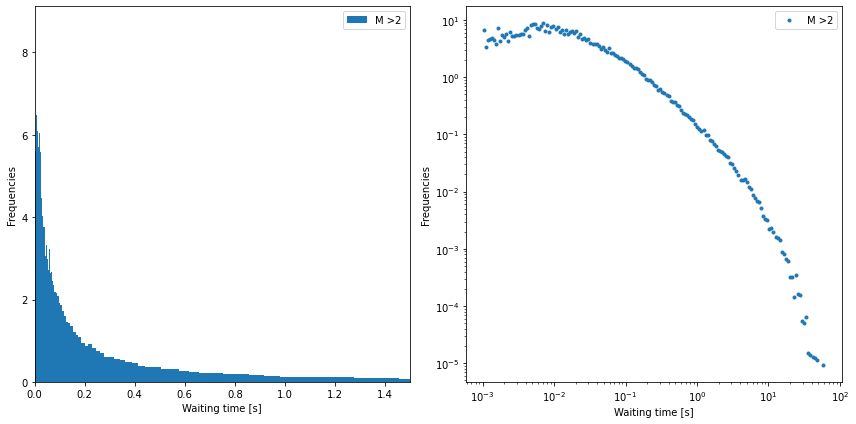

In [86]:
bl_mr2,cl_mr2, norm_mr2 = hist_plot_logbin_mean(wt2_mr,-3,1.5,1,m=2)

In [87]:
bl_mr3,cl_mr3, norm_mr3 = hist_plot_logbin_mean(wt3_mr,-3,1,1,m=3)
bl_mr4,cl_mr4, norm_mr4 = hist_plot_logbin_mean(wt4_mr,-3,0.5,1,m=4)
bl_mr5,cl_mr5, norm_mr5 = hist_plot_logbin_mean(wt5_mr,-3,2,1,m=5)
plt.close()

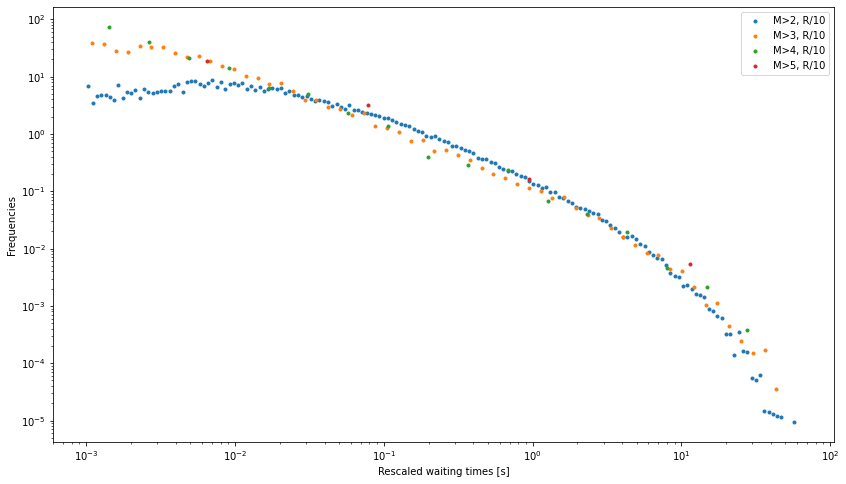

In [88]:
plt.figure(figsize=(14,8)) 
plt.plot(bl_mr2,cl_mr2,'.',label='M>2, R/10')
plt.plot(bl_mr3,cl_mr3,'.',label='M>3, R/10')
plt.plot(bl_mr4,cl_mr4,'.',label='M>4, R/10')
plt.plot(bl_mr5,cl_mr5,'.',label='M>5, R/10')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Rescaled waiting times [s]')
plt.ylabel('Frequencies')
plt.show()

We obtain another scaling picture also for the case of restricted dataset of waiting times by imposing a bound on the distances. Again all the distributions behave in the same way and tend to collapse in one.

## Fit

In [89]:
fit_wt_mr2=fit(bl_mr2,cl_mr2,3e-2,5e0)
fit_wt_mr3=fit(bl_mr3,cl_mr3,3e-2,5e0)
fit_wt_mr4=fit(bl_mr4,cl_mr4,3e-2,5e0)
fit_wt_mr5=fit(bl_mr5,cl_mr5,3e-2,2e1) #need more points

slope2 = np.round(fit_wt_mr2[0],2)
intercept2 = np.round(np.log10(fit_wt_mr2[1]),2)
err_slope2 = np.round(fit_wt_mr2[2],2)
err_intercept2 = np.round(fit_wt_mr2[3],2)


slope3 = np.round(fit_wt_mr3[0],2)
intercept3 = np.round(np.log10(fit_wt_mr3[1]),2)
err_slope3 = np.round(fit_wt_mr3[2],2)
err_intercept3 = np.round(fit_wt_mr3[3],2)

slope4 = np.round(fit_wt_mr4[0],2)
intercept4 = np.round(np.log10(fit_wt_mr4[1]),2)
err_slope4 = np.round(fit_wt_mr4[2],2)
err_intercept4 = np.round(fit_wt_mr4[3],2)


slope5 = np.round(fit_wt_mr5[0],2)
intercept5 = np.round(np.log10(fit_wt_mr5[1]),2)
err_slope5 = np.round(fit_wt_mr5[2],2)
err_intercept5 = np.round(fit_wt_mr5[3],2)


slopes = [slope2,err_slope2,slope3,err_slope3,slope4,err_slope4,slope5,err_slope5]
intercepts = [intercept2,err_intercept2,intercept3,err_intercept3,intercept4,err_intercept4,intercept5,err_intercept5]

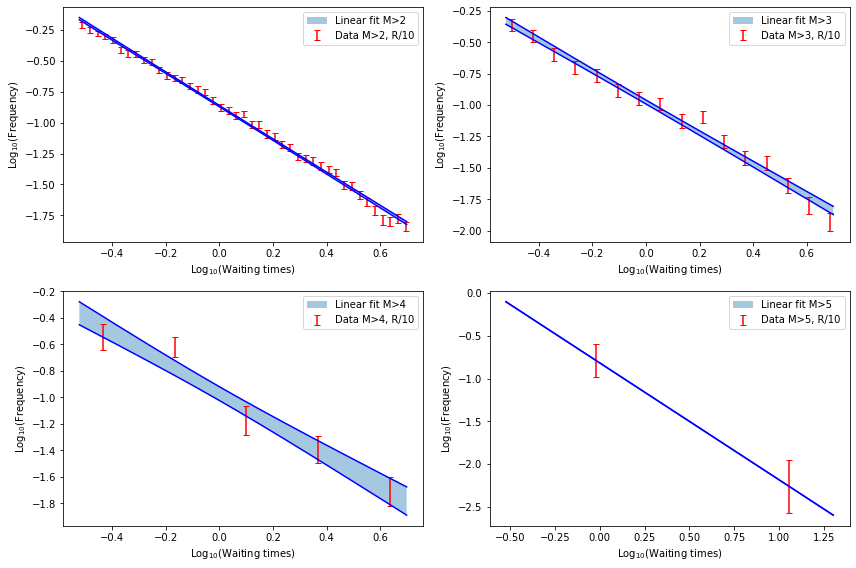

In [90]:
x_1,slope_1,intercept_1,err_line_1,mask_1,erry_1,bins_1,counts_1=linear_fit_plot(bl_mr2,cl_mr2,norm_mr2,3e-1,5e0)
x_2,slope_2,intercept_2,err_line_2,mask_2,erry_2,bins_2,counts_2=linear_fit_plot(bl_mr3,cl_mr3,norm_mr3,3e-1,5e0)
x_3,slope_3,intercept_3,err_line_3,mask_3,erry_3,bins_3,counts_3=linear_fit_plot(bl_mr4,cl_mr4,norm_mr4,3e-1,5e0)
x_4,slope_4,intercept_4,err_line_4,mask_4,erry_4,bins_4,counts_4=linear_fit_plot(bl_mr5,cl_mr5,norm_mr5,3e-1,2e1)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))

ax1.errorbar(np.log10(bins_1[mask_1]), np.log10(counts_1[mask_1]), 1/np.log(10)*1/counts_1[mask_1]*(erry_1), fmt='None',c='r',capsize=3,label='Data M>2, R/10')
ax1.fill_between(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,alpha=0.4,label='Linear fit M>2')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)+err_line_1,c='b')
ax1.plot(x_1,x_1*slope_1+np.log10(intercept_1)-err_line_1,c='b')
ax1.set_xlabel('Log$_{10}$(Waiting times)')
ax1.set_ylabel('Log$_{10}$(Frequency)')
ax1.legend(loc='best')

ax2.errorbar(np.log10(bins_2[mask_2]), np.log10(counts_2[mask_2]), 1/np.log(10)*1/counts_2[mask_2]*(erry_2), fmt='None',c='r',capsize=3,label='Data M>3, R/10')
ax2.fill_between(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,alpha=0.4,label='Linear fit M>3')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)+err_line_2,c='b')
ax2.plot(x_2,x_2*slope_2+np.log10(intercept_2)-err_line_2,c='b')
ax2.set_xlabel('Log$_{10}$(Waiting times)')
ax2.set_ylabel('Log$_{10}$(Frequency)')
ax2.legend(loc='best')

ax3.errorbar(np.log10(bins_3[mask_3]), np.log10(counts_3[mask_3]), 1/np.log(10)*1/counts_3[mask_3]*(erry_3), fmt='None',c='r',capsize=3,label='Data M>4, R/10')
ax3.fill_between(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,alpha=0.4,label='Linear fit M>4')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)+err_line_3,c='b')
ax3.plot(x_3,x_3*slope_3+np.log10(intercept_3)-err_line_3,c='b')
ax3.set_xlabel('Log$_{10}$(Waiting times)')
ax3.set_ylabel('Log$_{10}$(Frequency)')
ax3.legend(loc='best')

ax4.errorbar(np.log10(bins_4[mask_4]), np.log10(counts_4[mask_4]), 1/np.log(10)*1/counts_4[mask_4]*(erry_4), fmt='None',c='r',capsize=3,label='Data M>5, R/10')
ax4.fill_between(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,alpha=0.4,label='Linear fit M>5')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)+err_line_4,c='b')
ax4.plot(x_4,x_4*slope_4+np.log10(intercept_4)-err_line_4,c='b')
ax4.set_xlabel('Log$_{10}$(Waiting times)')
ax4.set_ylabel('Log$_{10}$(Frequency)')
ax4.legend(loc='best')

fig.tight_layout()

In [91]:
print('The results of the linear fits are: ','\n')
for i in range(0,3):
    print('Slope for fit M >',i+2, ' ', slopes[2*i], '+-', slopes[2*i+1],'   ', 'Intercept for fit M >',i+2, ' ', intercepts[2*i], '+-', intercepts[2*i+1] )

The results of the linear fits are:  

Slope for fit M > 2   -1.14 +- 0.02     Intercept for fit M > 2   -0.89 +- 0.01
Slope for fit M > 3   -1.13 +- 0.02     Intercept for fit M > 3   -1.0 +- 0.01
Slope for fit M > 4   -1.11 +- 0.05     Intercept for fit M > 4   -1.0 +- 0.04


## Conclusion

From our analysis, the power law distribution of waiting times and distances is evident. For the former, the power law exponent $B$ is between 0.8 and 0.9 (by applying a maximum range, this value updates to 0.9-1.1); for the latter, it is in the range 0.6-0.9. These values are compatible with the ones found in literature.

By rescaling the dataset, we found them to follow the same distribution: not only the linear region, but also the one of exponential decay.